# **Predicting ICU Mortality Within the First 24 Hours of Admission**

## A Machine Learning Approach Using the MIMIC-III Dataset

Author: Kaveh Sarraf

In [2]:
# =============================================================================
# Import Dependencies
# =============================================================================
from pathlib import Path
import logging
import logging.handlers
import pandas as pd
import numpy as np
import os
import datetime as dt
import glob
import traceback
from scipy import stats
import datetime
from dateutil.relativedelta import relativedelta
import warnings
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec, KeyedVectors
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from scipy.stats import linregress

import matplotlib.pyplot as plt

# =============================================================================
# Parameters
# =============================================================================

_PROCESS_NAME = 'Predicting_ICU_Mortality'
ERROR_COUNT = 0
ERROR_STR = ''

# =============================================================================
# Date Variables
# =============================================================================

now = dt.datetime.now()
today_str = now.strftime('%Y-%m-%d')

# =============================================================================
# Directories
# =============================================================================

# Set the path to the directory containing the MIMIC-III CSV files
data_path = r"D:\Documents\UNSW\HDAT 9910 - Capstone\UNSW MIMIC III\mimic_data\mimic_data\*.csv"

# Set the path to where output files will be stored
cwd = Path(r"D:\Python_Scripts\Projects\mimic_iii\Outputs")
cwd_str = str(cwd)

Set up logging

In [3]:
# =============================================================================
# Set up logging
# =============================================================================

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
log_file = os.path.join(cwd, F"{_PROCESS_NAME}_{today_str}.log")
handler = logging.handlers.RotatingFileHandler(log_file, maxBytes=1024 * 1024, backupCount=1)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

# Set up logging to console
console_handler = logging.StreamHandler()
console_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
console_handler.setFormatter(console_formatter)
logger.addHandler(console_handler)

logger.info(F"=== Starting {_PROCESS_NAME}.py ===")

2023-04-23 12:11:43,137 - INFO - === Starting Research_Question_1.py ===


Read MIMIC III Datasets

In [6]:
# =============================================================================
# Read mimic iii datasets
# =============================================================================


# Read the relevant datasets into Pandas dataframes
def load_datasets(data_path):
    '''
    Load multiple CSV files into separate pandas dataframes and return them as variables with updated names.

    Parameters
    ----------
    data_path : str
        The path to the directory containing the CSV files.

    Returns
    -------
    dict
        A dictionary mapping the updated names of the dataframes (without the ".csv" extension) to the dataframes.

    Raises
    ------
    Exception
        If an error occurs while reading the CSV files.

    Notes
    -----
    - This function reads all CSV files in the `data_path` directory and its subdirectories.
    - Each CSV file is read in chunks of 20,000 rows.
    - The resulting dataframes are concatenated and returned as variables with updated names.

    '''
    
    global ERROR_COUNT
    global ERROR_STR
    
    try:
        # Obtain the list of csv files to read
        files = glob.glob(data_path, recursive=True)
        
        # Create an empty list to hold the file names
        file_names = []
        
        # Create an empty list to hold the dataframe names
        df_names = []
        
        # Create an empty list to hold the chunks of data
        chunks = []
        
        # Create an empty list to keep each dataframe
        df_list = []
        
        # Create an empty dictionary to hold the dataframes
        df_dict = {}
        
        start = dt.datetime.now()
        
        for file in files:
            # Counter variable to keep track of chunk number
            counter = 1
            # Split the file path using the backslash as the separator
            parts = file.split('\\')
            # Extract the last part
            file_name = parts[-1]
            file_names.append(file_name)
            
            logger.info(F"Reading: {file_name}")
            # Read the file in chunks and concatenate the resulting dataframes
            df_list = []
            for chunk in pd.read_csv(file, 
                                     chunksize=20000):
            
                # Increment the counter variable
                counter += 1
                # Append each chunk to the list of dataframes
                df_list.append(chunk)
                
            df = pd.concat(df_list, ignore_index=True)
            # Remove the ".csv" extension from the file name and use it as the key in the dictionary
            df_name = file_name.replace('.csv', '')
            df_dict[df_name] = df
            
        finish = dt.datetime.now()
        elapsed_time = finish - start
        hours, remainder = divmod(elapsed_time.seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        
        logger.info("Finished reading ALL datasets")
        logger.info("Elapsed time: {} hours, {} minutes, {} seconds".format(hours, minutes, seconds))
        
        # Assign the dataframes to variables with the updated names
        for key, value in df_dict.items():
            locals()[key] = value
        
    except Exception as e:
        logger.info("Error occurred while reading datasets: {e}")
        logger.error(traceback.format_exc())
        ERROR_COUNT += 1
        ERROR_STR += F'{e}'
        
    return df_dict

# =============================================================================
# Load All datasets
# =============================================================================
# Call the load_datasets function to load the csv files into a dictionary
df_dict = load_datasets(data_path)

2023-04-22 10:22:19,401 - INFO - Reading: pt_icu_outcome.csv
2023-04-22 10:22:20,010 - INFO - Reading: vasopressors.csv
2023-04-22 10:22:21,162 - INFO - Reading: output_hourly.csv
2023-04-22 10:22:25,140 - INFO - Reading: antibiotics.csv
2023-04-22 10:22:26,432 - INFO - Reading: admissions.csv
2023-04-22 10:22:27,155 - INFO - Reading: pt_weight.csv
2023-04-22 10:22:29,190 - INFO - Reading: gcs_hourly.csv
2023-04-22 10:22:31,648 - INFO - Reading: transfers.csv
2023-04-22 10:22:33,280 - INFO - Reading: bloodculture.csv
2023-04-22 10:22:35,627 - INFO - Reading: patients.csv
2023-04-22 10:22:35,879 - INFO - Reading: icd9_diag.csv
2023-04-22 10:22:37,954 - INFO - Reading: labs_hourly.csv
2023-04-22 10:22:42,630 - INFO - Reading: icustays.csv
2023-04-22 10:22:43,039 - INFO - Reading: pt_stay_hr.csv
2023-04-22 10:23:04,449 - INFO - Reading: vitals_hourly.csv
2023-04-22 10:23:22,705 - INFO - Reading: pv_mechvent.csv
2023-04-22 10:23:27,476 - INFO - Finished reading ALL datasets
2023-04-22 10:2

### Data Pre-processing

----

1. Data Types

In [7]:
# =============================================================================
# ADMISSIONS
# =============================================================================

# Convert the admittime, dischtime, and deathtime columns to datetime data type in the admissions dataframe
df_dict['admissions']['admittime'] = pd.to_datetime(df_dict['admissions']['admittime'])
df_dict['admissions']['dischtime'] = pd.to_datetime(df_dict['admissions']['dischtime'])
df_dict['admissions']['deathtime'] = pd.to_datetime(df_dict['admissions']['deathtime'])
df_dict['admissions']['edregtime'] = pd.to_datetime(df_dict['admissions']['edregtime'])
df_dict['admissions']['edouttime'] = pd.to_datetime(df_dict['admissions']['edouttime'])

# =============================================================================
# ANTIBIOTICS
# =============================================================================

df_dict['antibiotics']['starttime'] = pd.to_datetime(df_dict['antibiotics']['starttime'])
df_dict['antibiotics']['endtime'] = pd.to_datetime(df_dict['antibiotics']['endtime'])

# =============================================================================
# BLOODCULTURE
# =============================================================================

df_dict['bloodculture']['charttime'] = pd.to_datetime(df_dict['bloodculture']['charttime'])
df_dict['bloodculture']['chartdate'] = pd.to_datetime(df_dict['bloodculture']['chartdate'])
df_dict['bloodculture']['positiveculture'] = df_dict['bloodculture']['positiveculture'].astype(bool)

# =============================================================================
# GCS_HOURLY
# =============================================================================

df_dict['gcs_hourly']['endotrachflag'] = df_dict['gcs_hourly']['endotrachflag'].astype(bool)

# =============================================================================
# ICUSTAYS
# =============================================================================

df_dict['icustays']['intime'] = pd.to_datetime(df_dict['icustays']['intime'])
df_dict['icustays']['outtime'] = pd.to_datetime(df_dict['icustays']['outtime'])

# =============================================================================
# PATIENTS
# =============================================================================

df_dict['patients']['dob'] = pd.to_datetime(df_dict['patients']['dob'])
df_dict['patients']['dod'] = pd.to_datetime(df_dict['patients']['dod'])
df_dict['patients']['dod_hosp'] = pd.to_datetime(df_dict['patients']['dod_hosp'])
df_dict['patients']['dod_ssn'] = pd.to_datetime(df_dict['patients']['dod_ssn'])
df_dict['patients']['expire_flag'] = df_dict['patients']['expire_flag'].astype(bool)

# =============================================================================
# PT_ICU_OUTCOME
# =============================================================================

df_dict['pt_icu_outcome']['dob'] = pd.to_datetime(df_dict['pt_icu_outcome']['dob'])
df_dict['pt_icu_outcome']['dod'] = pd.to_datetime(df_dict['pt_icu_outcome']['dod'])
df_dict['pt_icu_outcome']['admittime'] = pd.to_datetime(df_dict['pt_icu_outcome']['admittime'])
df_dict['pt_icu_outcome']['dischtime'] = pd.to_datetime(df_dict['pt_icu_outcome']['dischtime'])
df_dict['pt_icu_outcome']['intime'] = pd.to_datetime(df_dict['pt_icu_outcome']['intime'])
df_dict['pt_icu_outcome']['outtime'] = pd.to_datetime(df_dict['pt_icu_outcome']['outtime'])
df_dict['pt_icu_outcome']['hosp_deathtime'] = pd.to_datetime(df_dict['pt_icu_outcome']['hosp_deathtime'])
df_dict['pt_icu_outcome']['expire_flag'] = df_dict['pt_icu_outcome']['expire_flag'].astype(bool)
df_dict['pt_icu_outcome']['icu_expire_flag'] = df_dict['pt_icu_outcome']['icu_expire_flag'].astype(bool)
df_dict['pt_icu_outcome']['hospital_expire_flag'] = df_dict['pt_icu_outcome']['hospital_expire_flag'].astype(bool)

# =============================================================================
# PT_STAY_HR    
# =============================================================================

df_dict['pt_stay_hr']['intime'] = pd.to_datetime(df_dict['pt_stay_hr']['intime'])
df_dict['pt_stay_hr']['outtime'] = pd.to_datetime(df_dict['pt_stay_hr']['outtime'])
df_dict['pt_stay_hr']['starttime'] = pd.to_datetime(df_dict['pt_stay_hr']['starttime'])
df_dict['pt_stay_hr']['endtime'] = pd.to_datetime(df_dict['pt_stay_hr']['endtime'])

# =============================================================================
# PT_WEIGHT
# =============================================================================

df_dict['pt_weight']['starttime'] = pd.to_datetime(df_dict['pt_weight']['starttime'])
df_dict['pt_weight']['endtime'] = pd.to_datetime(df_dict['pt_weight']['endtime'])

# =============================================================================
# PV_MECHVENT
# =============================================================================

df_dict['pv_mechvent']['charttime'] = pd.to_datetime(df_dict['pv_mechvent']['charttime'])
df_dict['pv_mechvent']['starttime'] = pd.to_datetime(df_dict['pv_mechvent']['starttime'])
df_dict['pv_mechvent']['endtime'] = pd.to_datetime(df_dict['pv_mechvent']['endtime'])

# =============================================================================
# TRANSFERS
# =============================================================================

df_dict['transfers']['intime'] = pd.to_datetime(df_dict['transfers']['intime'])
df_dict['transfers']['outtime'] = pd.to_datetime(df_dict['transfers']['outtime'])

# =============================================================================
# VASOPRESSORS
# =============================================================================

df_dict['vasopressors']['starttime'] = pd.to_datetime(df_dict['vasopressors']['starttime'])
df_dict['vasopressors']['endtime'] = pd.to_datetime(df_dict['vasopressors']['endtime'])

# =============================================================================
# Get individual pandas dataframes from df_dict
# =============================================================================

# Sort keys of df_dict in alphabetical order
sorted_dict = {k: df_dict[k] for k in sorted(df_dict.keys())}
print(sorted_dict.keys())

(admissions, antibiotics, bloodculture, gcs_hourly, icd9_diag, icustays,
 labs_hourly, output_hourly, patients, pt_icu_outcome, pt_stay_hr, pt_weight,
 pv_mechvent, transfers, vasopressors, vitals_hourly) = sorted_dict.values()

dict_keys(['admissions', 'antibiotics', 'bloodculture', 'gcs_hourly', 'icd9_diag', 'icustays', 'labs_hourly', 'output_hourly', 'patients', 'pt_icu_outcome', 'pt_stay_hr', 'pt_weight', 'pv_mechvent', 'transfers', 'vasopressors', 'vitals_hourly'])


### Data Pre-processing

----

2. Filter data for first 24 hours since ICU Admission

In [8]:
logger.info("Filter data for first 24 hours since ICU Admission")

####################
### vasopressors ###
####################
# Merge the datasets on 'icustay_id'
vasopressors_merged = vasopressors.merge(icustays[['icustay_id', 'intime']], on='icustay_id')

# Calculate the time difference between 'starttime' and 'intime'
vasopressors_merged['time_from_intime'] = vasopressors_merged['starttime'] - vasopressors_merged['intime']

# Filter rows where 'time_from_intime' is less than or equal to 24 hours
vasopressors_first_24h = vasopressors_merged[vasopressors_merged['time_from_intime'] <= pd.Timedelta(hours=24)]

# Drop the unnecessary columns
vasopressors_first_24h = vasopressors_first_24h.drop(['intime', 'time_from_intime'], axis=1)
logger.info("Filtered Dataframe: vasopressors")

#####################
### output_hourly ###
#####################

# Filter rows where 'hr' is less than or equal to 24
output_hourly_first_24h = output_hourly[output_hourly['hr'] <= 24]
logger.info("Filtered Dataframe: output_hourly")

###################
### antibiotics ###
###################

# Merge the datasets on 'icustay_id'
antibiotics_merged = antibiotics.merge(icustays[['icustay_id', 'intime']], on='icustay_id')

# Calculate the time difference between 'starttime' and 'intime'
antibiotics_merged['time_from_intime'] = antibiotics_merged['starttime'] - antibiotics_merged['intime']

# Filter rows where 'time_from_intime' is less than or equal to 24 hours
antibiotics_first_24h = antibiotics_merged[antibiotics_merged['time_from_intime'] <= pd.Timedelta(hours=24)]

# Drop the unnecessary columns
antibiotics_first_24h = antibiotics_first_24h.drop(['intime', 'time_from_intime'], axis=1)
logger.info("Filtered Dataframe: antibiotics")

#################
### pt_weight ###
#################

pt_weight_first_24h = pt_weight[pt_weight['dy'] <= 1]
logger.info("Filtered Dataframe: pt_weight")

##################
### gcs_hourly ###
##################

# Filter rows where 'hr' is less than or equal to 24
gcs_hourly_first_24h = gcs_hourly[gcs_hourly['hr'] <= 24]
logger.info("Filtered Dataframe: gcs_hourly")

#################
### transfers ###
#################

# Merge the datasets on 'icustay_id'
transfers_merged = transfers.merge(icustays[['icustay_id', 'intime']], on='icustay_id')

# Calculate the time difference between 'intime' in transfers and 'intime' in icustays
transfers_merged['time_from_icu_intime'] = transfers_merged['intime_x'] - transfers_merged['intime_y']

# Filter rows where 'time_from_icu_intime' is less than or equal to 24 hours
transfers_first_24h = transfers_merged[transfers_merged['time_from_icu_intime'] <= pd.Timedelta(hours=24)]

# Drop the unnecessary columns
transfers_first_24h = transfers_first_24h.drop(['intime_y', 'time_from_icu_intime'], axis=1)
transfers_first_24h.rename(columns={'intime_x': 'intime'}, inplace=True)
logger.info("Filtered Dataframe: transfers")

####################
### bloodculture ###
####################
# merge the bloodculture table with the icustays table
merged_bloodculture = bloodculture.merge(icustays[['icustay_id', 'intime']], on='icustay_id')

# calculate the time difference between the chartdate in bloodculture and intime in icustays
merged_bloodculture['time_from_icu_intime'] = merged_bloodculture['chartdate'] - merged_bloodculture['intime']

# filter the rows where the time_from_icu_intime is less than or equal to 24 hours:
bloodculture_first_24h = merged_bloodculture[merged_bloodculture['time_from_icu_intime'] <= pd.Timedelta('24 hours')]
logger.info("Filtered Dataframe: bloodculture")

###################
### labs_hourly ###
###################

# Filter rows where 'hr' is less than or equal to 24
labs_hourly_first_24h = labs_hourly[labs_hourly['hr'] <= 24]
logger.info("Filtered Dataframe: labs_hourly")

##################
### pt_stay_hr ###
##################

# Filter rows where 'hr' is less than or equal to 24
pt_stay_hr_first_24h = pt_stay_hr[pt_stay_hr['hr'] <= 24]
logger.info("Filtered Dataframe: pt_stay_hr")

#####################
### vitals_hourly ###
#####################

# Filter rows where 'hr' is less than or equal to 24
vitals_hourly_first_24h = vitals_hourly[vitals_hourly['hr'] <= 24]
logger.info("Filtered Dataframe: vitals_hourly")

###################
### pv_mechvent ###
###################

# Merge the datasets on 'icustay_id'
pv_mechvent_merged = pv_mechvent.merge(icustays[['icustay_id', 'intime']], on='icustay_id')

# Calculate the time from ICU admission to the start of each vent event
pv_mechvent_merged['time_from_intime_start'] = (pv_mechvent_merged['starttime'] - pv_mechvent_merged['intime']).dt.total_seconds() / 3600

# Calculate the time from ICU admission to the end of each vent event
pv_mechvent_merged['time_from_intime_end'] = (pv_mechvent_merged['endtime'] - pv_mechvent_merged['intime']).dt.total_seconds() / 3600

# Filter rows where the vent event starts within the first 24 hours of ICU admission
pv_mechvent_first_24h = pv_mechvent_merged[(pv_mechvent_merged['time_from_intime_start'] <= 24)]

# Drop the unnecessary columns
pv_mechvent_first_24h = pv_mechvent_first_24h.drop(['intime', 'time_from_intime_start', 'time_from_intime_end'], axis=1)
logger.info("Filtered Dataframe: pv_mechvent")

2023-04-22 10:24:05,599 - INFO - Filter data for first 24 hours since ICU Admission
2023-04-22 10:24:06,721 - INFO - Filtered Dataframe: vasopressors
2023-04-22 10:24:07,522 - INFO - Filtered Dataframe: output_hourly
2023-04-22 10:24:07,961 - INFO - Filtered Dataframe: antibiotics
2023-04-22 10:24:08,087 - INFO - Filtered Dataframe: pt_weight
2023-04-22 10:24:08,279 - INFO - Filtered Dataframe: gcs_hourly
2023-04-22 10:24:08,570 - INFO - Filtered Dataframe: transfers
2023-04-22 10:24:09,148 - INFO - Filtered Dataframe: bloodculture
2023-04-22 10:24:09,286 - INFO - Filtered Dataframe: labs_hourly
2023-04-22 10:24:10,269 - INFO - Filtered Dataframe: pt_stay_hr
2023-04-22 10:24:11,332 - INFO - Filtered Dataframe: vitals_hourly
2023-04-22 10:24:13,662 - INFO - Filtered Dataframe: pv_mechvent


### Data Pre-processing

----

3. Handle Missing Values

In [9]:
logger.info("Handling Missing Values")

###################
### antibiotics ###
###################

# Drop 'rate' and 'rateuom' columns since all values are blank 
antibiotics_first_24h = antibiotics_first_24h.drop(columns=['rate', 'rateuom'])
logger.info("antibiotics - Completed")

#################
### transfers ###
#################

'''
For outtime and los:
The missing values in these columns may indicate that the patients are still in the ICU or there is an error in the data collection. 
Lets remove the rows with missing values since there are only 6 records with missing values
'''
transfers_first_24h.dropna(subset=['outtime', 'los'], inplace=True)

transfers_first_24h.drop_duplicates(subset=['subject_id', 'hadm_id', 'icustay_id', 'dbsource',
       'eventtype', 'intime', 'outtime', 'los'], inplace=True)
logger.info("transfers - Completed")

####################
### bloodculture ###
####################
'''
For icustay_id and dy:
Remove the rows with missing values, as imputing them might not make sense:
'''
bloodculture_first_24h.dropna(subset=['icustay_id', 'dy'], inplace=True)

'''
For org_name:
Since the missing values in this column corresponds with positiveculture=False, 
it would indicate indicate that no organism was identified in the blood culture. 
Lets replace the missing values with a placeholder value and create a new category for these cases:
'''
bloodculture_first_24h['org_name'].fillna('No_Organism', inplace=True)

'''
For ab_name and antibioticresistance:
The missing values in these columns likely indicate that no resistance was detected. 
Lets replace the missing values with a placeholder value and create a new category for these cases:
'''
bloodculture_first_24h['ab_name'].fillna('No_Antibiotic', inplace=True)
bloodculture_first_24h['antibioticresistance'].fillna('No_Resistance', inplace=True)
logger.info("bloodculture - Completed")

##################
### pt_stay_hr ###
##################
# Create a boolean mask for rows with missing values
missing_values_mask = pt_stay_hr_first_24h.isnull().any(axis=1)

# Select the rows with missing values using the mask
rows_with_missing_values = pt_stay_hr_first_24h[missing_values_mask]

# replace the 'dy' value with 1 when 'dy' is NaN and 'hr' is 24 
pt_stay_hr_first_24h.loc[(pt_stay_hr_first_24h['dy'].isnull()) & (pt_stay_hr_first_24h['hr'] == 24), 'dy'] = 1
logger.info("pt_stay_hr - Completed")

#####################
### vitals_hourly ###
#####################
vitals_hourly_first_24h.sort_values(by=['icustay_id','hr'], inplace=True)

# Drop the fio2 column since there are too many missing values still (1,032,957)
vitals_hourly_first_24h = vitals_hourly_first_24h.drop(['fio2'], axis=1)
logger.info("vitals_hourly - Completed")


2023-04-22 10:24:29,294 - INFO - Handling Missing Values
2023-04-22 10:24:29,317 - INFO - antibiotics - Completed
2023-04-22 10:24:29,505 - INFO - transfers - Completed
2023-04-22 10:24:29,637 - INFO - bloodculture - Completed
2023-04-22 10:24:29,727 - INFO - pt_stay_hr - Completed
2023-04-22 10:24:30,500 - INFO - vitals_hourly - Completed


### Feature Engineering

In [10]:
###################
### antibiotics ###
###################

# Total antibiotics administered: Calculate the total number of unique antibiotics administered to each patient during the first 24 hours in the ICU.
total_antibiotics = antibiotics_first_24h.groupby('icustay_id')['label'].nunique().reset_index()
total_antibiotics.rename(columns={'label': 'total_unique_antibiotics'}, inplace=True)
logger.info("Feature Engineering completed for: antibiotics")

##################
### admissions ###
##################

admissions_copy = admissions.copy()

# Create a new binary feature 'weekend_admission' that indicates whether a patient was admitted to the ICU on a weekend (Saturday or Sunday)
admissions_copy['weekend_admission'] = admissions_copy['admittime'].apply(lambda x: x.weekday() >= 5).astype(int)

# Create 'hospital_mortality' feature using hospital_expire_flag column
admissions_copy['hospital_mortality'] = admissions_copy['hospital_expire_flag']

# Extract relevant features from datetime columns
admissions_copy['admit_day_of_week'] = admissions_copy['admittime'].dt.dayofweek
admissions_copy['admit_month'] = admissions_copy['admittime'].dt.month
admissions_copy['admit_year'] = admissions_copy['admittime'].dt.year

# Create a new boolean column called 'after_hours_admission' in the 'admissions_copy' DataFrame
# The 'apply' function is used to apply a custom lambda function to each row in the 'admittime' column
# The lambda function checks if the time of 'admittime' is between 18:01 and 6:00
# If the time is within this range, the value in the 'after_hours_admission' column is set to True, otherwise it is set to False
admissions_copy['after_hours_admission'] = admissions_copy['admittime'].apply(
    lambda x: True if (x.time() >= datetime.time(18, 1) or x.time() <= datetime.time(6, 0)) else False
)

# Drop the original datetime columns
admissions_copy.drop(['row_id', 'admittime', 'dischtime', 'deathtime', 'edregtime', 'edouttime', 'hospital_expire_flag', 'diagnosis'], axis=1, inplace=True)

# Convert categorical variables to numeric representations (one-hot encoding)
admissions_copy = pd.get_dummies(admissions_copy, columns=['admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity'])

def clean_feature_names(column_names):
    cleaned_columns = []
    for name in column_names:
        name = name.replace('<', 'less_than_')
        name = name.replace('>', 'greater_than_')
        name = name.replace('*', '_')
        name = re.sub(r'[/\-(),]', '_', name)
        name = re.sub(r'\[|\]', '', name)
        name = re.sub(r'\s', '_', name)  # Replace whitespaces with underscores
        cleaned_columns.append(name)
    return cleaned_columns

cleaned_columns = clean_feature_names(admissions_copy.columns)
admissions_copy.columns = cleaned_columns

def remove_double_underscores(column_name):
    return re.sub(r'_{2,}', '_', column_name)

# Apply the function to column names
new_column_names = [remove_double_underscores(col) for col in admissions_copy.columns]
# Update the dataframe column names
admissions_copy.columns = new_column_names
logger.info("Feature Engineering completed for: admissions")

#################
### pt_weight ###
#################

# Use the most reliable weight measurement. This is the the most relevant weight measurement for each patient within the first 24 hours of their ICU stay.
pt_weight_first_24h_mean = pt_weight_first_24h.groupby('icustay_id')['avg_weight_naive'].mean().reset_index()
logger.info("Feature Engineering completed for: pt_weight")

#####################
### output_hourly ###
#####################

# Total urine output: Calculate the total urine output for each patient during the first 24 hours in the ICU
# Filter the DataFrame to only include rows where 'hr' is between 0 and 24 (inclusive)
filtered_output_hourly = output_hourly_first_24h[(output_hourly_first_24h['hr'] >= 0) & (output_hourly_first_24h['hr'] <= 24)]
total_urine_output = filtered_output_hourly.groupby('icustay_id')['urineoutput'].sum().reset_index()
total_urine_output.rename(columns={'urineoutput': 'total_urineoutput_24h'}, inplace=True)

# Mean hourly urine output: Calculate the mean hourly urine output for each patient during the first 24 hours in the ICU.
mean_hourly_urine_output = output_hourly_first_24h.groupby('icustay_id')['urineoutput'].mean().reset_index()
mean_hourly_urine_output.rename(columns={'urineoutput': 'mean_hourly_urineoutput'}, inplace=True)

# Minimum and maximum hourly urine output: Calculate the minimum and maximum hourly urine output for each patient during the first 24 hours in the ICU.
min_max_hourly_urine_output = output_hourly_first_24h.groupby('icustay_id')['urineoutput'].agg(['min', 'max']).reset_index()
min_max_hourly_urine_output.rename(columns={'min': 'min_hourly_urineoutput', 'max': 'max_hourly_urineoutput'}, inplace=True)

# Merge the aggregated features: Merge the total, mean, minimum, and maximum urine output features into a single dataframe.
output_agg = total_urine_output.merge(mean_hourly_urine_output, on='icustay_id').merge(min_max_hourly_urine_output, on='icustay_id')
logger.info("Feature Engineering completed for: output_hourly")

####################
### vasopressors ###
####################

# Presence of vasopressors
def presence_flag(x):
    return 1 if any(x > 0) else 0

vasopressors_presence = vasopressors_first_24h.groupby('icustay_id')[['norepinephrine_rate', 'epinephrine_rate', 'dopamine_rate', 'dobutamine_rate']].agg(presence_flag).reset_index()

# Define the new column names
new_column_names = {
    'norepinephrine_rate': 'norepinephrine_used',
    'epinephrine_rate': 'epinephrine_used',
    'dopamine_rate': 'dopamine_used',
    'dobutamine_rate': 'dobutamine_used'
    }

# Rename the columns
vasopressors_presence = vasopressors_presence.rename(columns=new_column_names)


# Number of vasopressor types used
vasopressors_first_24h['num_vasopressor_types'] = vasopressors_first_24h[['norepinephrine_rate', 'epinephrine_rate', 'dopamine_rate', 'dobutamine_rate']].apply(lambda x: (x != 0).astype(int).sum(), axis=1)
vasopressors_count = vasopressors_first_24h.groupby('icustay_id')['num_vasopressor_types'].max().reset_index()

# Merge the aggregated features: This will make it easier to combine with other datasets and use as input for a machine learning model. 
vasopressors_agg = vasopressors_presence.merge(vasopressors_count, on='icustay_id')

# Define the custom function to check if any specified column value is 1 in the row
def any_vasopressor_used(row):
    columns_to_check = ['norepinephrine_used', 'epinephrine_used', 'dopamine_used', 'dobutamine_used']
    return int(any(row[column] == 1 for column in columns_to_check))

# Apply the custom function to each row in the vasopressors_presence DataFrame
vasopressors_agg['any_vasopressor_used'] = vasopressors_agg.apply(any_vasopressor_used, axis=1)
logger.info("Feature Engineering completed for: vasopressors")

##################
### gcs_hourly ###
##################

# Average GCS score: Calculate the average GCS score for each patient during the first 24 hours in the ICU.
avg_gcs = gcs_hourly_first_24h.groupby('icustay_id')['gcs'].mean().reset_index()
avg_gcs.rename(columns={'gcs': 'avg_gcs'}, inplace=True)

# Minimum and maximum GCS scores: Calculate the minimum and maximum GCS scores for each patient during the first 24 hours in the ICU.
min_gcs = gcs_hourly_first_24h.groupby('icustay_id')['gcs'].min().reset_index()
min_gcs.rename(columns={'gcs': 'min_gcs'}, inplace=True)

max_gcs = gcs_hourly_first_24h.groupby('icustay_id')['gcs'].max().reset_index()
max_gcs.rename(columns={'gcs': 'max_gcs'}, inplace=True)

# Add a boolean feature called endotracheal_intubation that indicates whether each icustay_id received endotracheal intubation
endotracheal_intubation = gcs_hourly_first_24h.groupby('icustay_id')['endotrachflag'].max().reset_index()
endotracheal_intubation.rename(columns={'endotrachflag': 'endotracheal_intubation'}, inplace=True)

# Endotracheal intubation: Calculate the proportion of endotracheal intubations (endotrachflag == 1) for each patient during the first 24 hours in the ICU.
endotrach_proportion = gcs_hourly_first_24h.groupby('icustay_id')['endotrachflag'].mean().reset_index()
endotrach_proportion.rename(columns={'endotrachflag': 'endotrach_proportion'}, inplace=True)

# Merge the aggregated features:
gcs_agg = avg_gcs.merge(min_gcs, on='icustay_id').merge(max_gcs, on='icustay_id').merge(endotrach_proportion, on='icustay_id').merge(endotracheal_intubation, on='icustay_id')
gcs_agg['avg_gcs'] = gcs_agg['avg_gcs'].round(0)
gcs_agg['endotrach_proportion'] = gcs_agg['endotrach_proportion'].round(2)
gcs_agg['gcs_measured'] = True
logger.info("Feature Engineering completed for: gcs_hourly")

#################
### transfers ###
#################

# Identify patients transferred
transfers_first_24h['patient_transferred'] = transfers_first_24h['eventtype'].apply(lambda x: False if x in ['admit', 'discharge'] else True)

# 1. Number of transfers: Calculate the total number of transfers for each icustay_id.
num_transfers = transfers_first_24h.groupby('icustay_id').agg({'patient_transferred': 'sum'}).reset_index()
num_transfers.rename(columns={'patient_transferred': 'num_transfers'}, inplace=True)


# 2. Total transfer time: Calculate the total time spent during transfers for each icustay_id.

# Helper function to calculate transfer_time for each icustay_id
def calculate_transfer_time(group):
    admit_present = 'admit' in group['eventtype'].values
    transfer_present = 'transfer' in group['eventtype'].values
    transfer_count = group[group['eventtype'] == 'transfer'].shape[0]

    group['transfer_time'] = 0

    if admit_present and transfer_present:
        for i in range(1, len(group)):
            group.loc[group.index[i], 'transfer_time'] = group.loc[group.index[i], 'intime'] - group.loc[group.index[i - 1], 'outtime']
    elif transfer_present and transfer_count > 1:
        for i in range(1, len(group)):
            group.loc[group.index[i], 'transfer_time'] = group.loc[group.index[i], 'intime'] - group.loc[group.index[i - 1], 'outtime']

    return group

# Sort the dataframe
transfers_first_24h_sorted = transfers_first_24h.sort_values(['icustay_id', 'eventtype', 'intime', 'outtime'])

# Group the sorted dataframe by icustay_id and apply the helper function
transfers_first_24h_sorted = transfers_first_24h_sorted.groupby('icustay_id', group_keys=False).apply(calculate_transfer_time)
# Convert the 'transfer_time' column to timedelta type
transfers_first_24h_sorted['transfer_time'] = pd.to_timedelta(transfers_first_24h_sorted['transfer_time'])
# Convert transfer_time to seconds
transfers_first_24h_sorted['transfer_time'] = transfers_first_24h_sorted['transfer_time'].dt.total_seconds()

# Calculate the total time spent during transfers for each icustay_id
total_transfer_time = transfers_first_24h_sorted.groupby('icustay_id')['transfer_time'].sum().reset_index()
total_transfer_time['transfer_time'] = total_transfer_time['transfer_time'].round(0)

# 3. Average transfer time: Calculate the average time spent during transfers for each icustay_id.
avg_transfer_time = transfers_first_24h_sorted.groupby('icustay_id')['transfer_time'].mean().reset_index()
avg_transfer_time.rename(columns={'transfer_time': 'avg_transfer_time'}, inplace=True)
avg_transfer_time['avg_transfer_time'] = avg_transfer_time['avg_transfer_time'].round(0)

# Merge the features into a single dataframe
transfers_agg = num_transfers.merge(total_transfer_time, on='icustay_id').merge(avg_transfer_time, on='icustay_id')
logger.info("Feature Engineering completed for: transfers")

####################
### bloodculture ###
####################

# 1. Calculate the number of positive cultures for each icustay_id
# Filter only positive cultures
positive_cultures_df = bloodculture_first_24h[bloodculture_first_24h['positiveculture'] == 1]
# Calculate the number of unique positive cultures for each icustay_id
unique_positive_cultures = positive_cultures_df.groupby('icustay_id')['org_name'].nunique().reset_index()
unique_positive_cultures.columns = ['icustay_id', 'num_unique_positive_cultures']


# 2. Calculate the number of antibiotic resistance instances for each icustay_id
# Create a boolean 'resistance_flag' column
bloodculture_first_24h['resistance_flag'] = bloodculture_first_24h['antibioticresistance'] == 'R'
antibiotic_resistances = bloodculture_first_24h[bloodculture_first_24h['resistance_flag']].groupby('icustay_id')['ab_name'].nunique().reset_index()
antibiotic_resistances.rename(columns={'ab_name': 'num_unique_antibiotic_resistances'}, inplace=True)

# 3. Calculate the number of antibiotic susceptibility instances for each icustay_id
# Create a boolean flag called 'susceptible_flag'
bloodculture_first_24h['susceptible_flag'] = bloodculture_first_24h['antibioticresistance'].isin(['S', 'I'])

# Filter rows where 'susceptible_flag' is True
susceptible_cultures = bloodculture_first_24h[bloodculture_first_24h['susceptible_flag']]

# Group by icustay_id and calculate the number of unique ab_name where 'susceptible_flag' is True
unique_susceptible_cultures = susceptible_cultures.groupby('icustay_id')['ab_name'].nunique().reset_index()
unique_susceptible_cultures.columns = ['icustay_id', 'num_unique_susceptible_cultures']


# 4. Create a boolean flag for blood culture tests presence
bloodculture_presence = bloodculture_first_24h[['icustay_id']].drop_duplicates()
bloodculture_presence['bloodculture_tested'] = True

# Merge the created features into a single DataFrame
bloodculture_features = bloodculture_presence.merge(antibiotic_resistances, on='icustay_id', how='left').merge(unique_positive_cultures, on='icustay_id', how='left').merge(unique_susceptible_cultures, on='icustay_id', how='left')

# Fill NaN values with 0 for 'num_positive_cultures' and 'num_antibiotic_resistances'
bloodculture_features[['num_unique_positive_cultures', 'num_unique_antibiotic_resistances', 'num_unique_susceptible_cultures']] = bloodculture_features[['num_unique_positive_cultures', 'num_unique_antibiotic_resistances', 'num_unique_susceptible_cultures']].fillna(0)
logger.info("Feature Engineering completed for: bloodculture")

###################
### labs_hourly ###
###################

# Obtain gender
# Merge labs_hourly_first_24h with icustays on icustay_id
labs_icustays_merged = labs_hourly_first_24h.merge(icustays[['icustay_id', 'subject_id']], on='icustay_id')

# Merge labs_icustays_merged with patients on subject_id to get the gender
labs_icustays_patients_merged = labs_icustays_merged.merge(patients[['subject_id', 'gender']], on='subject_id')

'''
To feature engineer the labs_hourly_first_24h dataset:

1) Calculate the mean, minimum, and maximum values for each lab test (e.g., neutrophil, creatinine, etc.) per icustay_id.
2) Calculate the number of lab tests performed for each icustay_id.
3) Create binary features indicating the availability of each lab test result (e.g., neutrophil_available, creatinine_available, etc.) for each icustay_id.
'''

## Step 1: Calculate mean, min, and max values for each lab test per icustay_id
lab_test_columns = ['neutrophil', 'creactiveprotein', 'whitebloodcell',
                    'partialpressureo2', 'bicarbonate', 'lactate', 'troponin',
                    'bloodureanitrogen', 'creatinine', 'alaninetransaminase',
                    'aspartatetransaminase', 'hemoglobin', 'intnormalisedratio',
                    'platelets', 'albumin', 'chloride', 'glucose', 'sodium', 'bilirubin',
                    'hematocrit']

lab_stats = labs_icustays_patients_merged.groupby(['icustay_id', 'gender'])[lab_test_columns].agg(['mean', 'min', 'max']).reset_index()
lab_stats.columns = ['_'.join(col).strip() for col in lab_stats.columns.values]
lab_stats.rename(columns={'icustay_id_':'icustay_id', 'gender_':'gender'}, inplace=True)

# now create 4 categories:low, normal, high, not-tested for each test
'''
To create binary features indicating whether a patient's lab test result is within the normal range, above the normal range, or below the normal range or missing, you need to define the normal ranges for each lab test. Once you have the normal ranges, you can create the binary features by comparing the test results with the normal range limits.

Here's a general outline for creating the binary features:

Define the normal ranges for each lab test.
Create binary features by comparing the test results with the normal range limits.
Assuming you have a dictionary containing the normal ranges for each lab test as follows:
'''
normal_ranges = {
    'neutrophil': {'low': 45, 'high': 70, 'not_tested': np.nan},
    'creactiveprotein': {'low': 0, 'high': 0.8, 'not_tested': np.nan},
    'whitebloodcell': {'low': 4.5, 'high': 11, 'not_tested': np.nan},
    'partialpressureo2': {'low': 80, 'high': 100, 'not_tested': np.nan},
    'bicarbonate': {'low': 23, 'high': 28, 'not_tested': np.nan},
    'lactate': {'low': 0.7, 'high': 2.1, 'not_tested': np.nan},
    'troponin': {'low': 0, 'high': 0.05, 'not_tested': np.nan},
    'bloodureanitrogen': {'low': 45, 'high': 70, 'not_tested': np.nan},
    'alaninetransaminase': {'low': 10, 'high': 40, 'not_tested': np.nan},
    'aspartatetransaminase': {'low': 10, 'high': 40, 'not_tested': np.nan},
    'intnormalisedratio': {'low': 2, 'high': 3, 'not_tested': np.nan},
    'platelets': {'low': 150, 'high': 450, 'not_tested': np.nan},
    'albumin': {'low': 3.5, 'high': 5.5, 'not_tested': np.nan},
    'chloride': {'low': 98, 'high': 106, 'not_tested': np.nan},
    'glucose': {'low': 70, 'high': 99, 'not_tested': np.nan},
    'sodium': {'low': 136, 'high': 145, 'not_tested': np.nan},
    'bilirubin': {'low': 0.3, 'high': 1.0, 'not_tested': np.nan},
}

# You can then create the binary features:
# Loop through all the lab tests in normal_ranges
def get_range(value, low, high, not_tested):
    if pd.isnull(value):
        return 'not_tested'
    elif value < low:
        return 'low'
    elif value > high:
        return 'high'
    else:
        return 'normal'

for lab_test, ranges in normal_ranges.items():
    low = ranges['low']
    high = ranges['high']
    not_tested = ranges['not_tested']

    lab_stats[f'{lab_test}_range'] = lab_stats[f'{lab_test}_mean'].apply(
        lambda x: get_range(x, low, high, not_tested)
    )

gender_specific_normal_ranges = {
    'creatinine': {
        'M': {'low': 0.7, 'high': 1.3, 'not_tested': np.nan},
        'F': {'low': 0.5, 'high': 1.1, 'not_tested': np.nan},
    },
    'hemoglobin': {
        'M': {'low': 14, 'high': 18, 'not_tested': np.nan},
        'F': {'low': 12, 'high': 16, 'not_tested': np.nan},
    },
    'hematocrit': {
        'M': {'low': 42, 'high': 50, 'not_tested': np.nan},
        'F': {'low': 37, 'high': 47, 'not_tested': np.nan},
    },
}

def get_gender_specific_range(value, gender, low, high, not_tested):
    if pd.isnull(value):
        return 'not_tested'
    elif gender == 'M':
        if value < low['M']:
            return 'low'
        elif value > high['M']:
            return 'high'
        else:
            return 'normal'
    else:  # gender == 'F'
        if value < low['F']:
            return 'low'
        elif value > high['F']:
            return 'high'
        else:
            return 'normal'

for lab_test, ranges in gender_specific_normal_ranges.items():
    low = {'M': ranges['M']['low'], 'F': ranges['F']['low']}
    high = {'M': ranges['M']['high'], 'F': ranges['F']['high']}
    not_tested = {'M': ranges['M']['not_tested'], 'F': ranges['F']['not_tested']}

    lab_stats[f'{lab_test}_range'] = lab_stats.apply(
        lambda row: get_gender_specific_range(row[f'{lab_test}_mean'], row['gender'], low, high, not_tested), axis=1
    )

## Step 2: Calculate the maximum lab_test_number for each icustay_id
lab_test_range_columns = [f'{lab_test}_range' for lab_test in lab_test_columns]
lab_stats['lab_test_count'] = lab_stats[lab_test_range_columns].apply(lambda row: sum([1 for x in row if x != 'not_tested']), axis=1)

columns_to_keep = ['icustay_id', 'gender', 'lab_test_count', 'creatinine_range',
       'hemoglobin_range', 'hematocrit_range', 'neutrophil_range',
       'creactiveprotein_range', 'whitebloodcell_range',
       'partialpressureo2_range', 'bicarbonate_range', 'lactate_range',
       'troponin_range', 'bloodureanitrogen_range',
       'alaninetransaminase_range', 'aspartatetransaminase_range',
       'intnormalisedratio_range', 'platelets_range', 'albumin_range',
       'chloride_range', 'glucose_range', 'sodium_range', 'bilirubin_range']

lab_stats_trimmed = lab_stats[columns_to_keep]
logger.info("Feature Engineering completed for: labs_hourly")

################
### patients ###
################

# Merge the dataframes on 'subject_id'
patient_icu = pd.merge(patients, icustays, on='subject_id')

# Convert 'intime' and 'dob' to pandas Timestamp
patient_icu['intime'] = pd.to_datetime(patient_icu['intime'])
patient_icu['dob'] = pd.to_datetime(patient_icu['dob'])

# Calculate age in years and months
patient_icu['age'] = patient_icu.apply(lambda row: relativedelta(row['intime'], row['dob']).years + relativedelta(row['intime'], row['dob']).months / 12, axis=1)

# Set ages below 0 to 0
patient_icu.loc[patient_icu['age'] < 0, 'age'] = 0

patient_icu['age'] = patient_icu['age'].round(0)

columns_to_keep = ['subject_id', 'hadm_id', 'icustay_id', 'gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn',
       'expire_flag', 'first_careunit', 'last_careunit', 'first_wardid', 'last_wardid',
       'intime', 'outtime', 'los', 'age']

patient_icu_trimmed = patient_icu[columns_to_keep]
logger.info("Feature Engineering completed for: patients")

#####################
### vitals_hourly ###
#####################

'''
Feature engineer the vitals_hourly_first_24h table by extracting various summary statistics (mean, min, max, etc.) 
for each patient's (icustay_id) vital signs during the first 24 hours of their ICU stay.
'''

vitals_columns = ['spo2', 'temperature', 'resprate', 'heartrate','sysbp', 'diasbp', 'glucose', 'meanarterialpressure']

vitals_stats = vitals_hourly_first_24h.groupby(['icustay_id'])[vitals_columns].agg(['mean', 'min', 'max']).reset_index()
vitals_stats.columns = ['_'.join(col).strip() for col in vitals_stats.columns.values]
vitals_stats.rename(columns={'icustay_id_':'icustay_id'}, inplace=True)

# Merge vitals_stats with patient_icu on icu_stay_id
vitals_stats = vitals_stats.merge(patient_icu[['icustay_id', 'age']], on='icustay_id', how='left')

spo2_ranges = {
    "age_<1": {"low": 95, "high": 100},
    "age_1-3": {"low": 95, "high": 100},
    "age_4-6": {"low": 95, "high": 100},
    "age_7-12": {"low": 95, "high": 100},
    "age_13-18": {"low": 95, "high": 100},
    "age_19-65": {"low": 95, "high": 100},
    "age_>65": {"low": 95, "high": 100},
}

temperature_ranges = {
    "age_<1": {"low": 36.7, "high": 37.3},
    "age_1-3": {"low": 36.4, "high": 37.4},
    "age_4-6": {"low": 36.4, "high": 37.4},
    "age_7-12": {"low": 36.4, "high": 37.4},
    "age_13-18": {"low": 36.4, "high": 37.4},
    "age_19-65": {"low": 35.6, "high": 36.7},
    "age_>65": {"low": 33.9, "high": 37.0},
}

resprate_ranges = {
    "age_<1": {"low": 30, "high": 60},
    "age_1-3": {"low": 24, "high": 40},
    "age_4-6": {"low": 22, "high": 34},
    "age_7-12": {"low": 18, "high": 30},
    "age_13-18": {"low": 12, "high": 16},
    "age_19-65": {"low": 12, "high": 20},
    "age_>65": {"low": 12, "high": 20},
}

heartrate_ranges = {
    "age_<1": {"low": 70, "high": 190},
    "age_1-3": {"low": 80, "high": 130},
    "age_4-6": {"low": 75, "high": 115},
    "age_7-12": {"low": 70, "high": 110},
    "age_13-18": {"low": 60, "high": 100},
    "age_19-65": {"low": 60, "high": 100},
    "age_>65": {"low": 60, "high": 100},
}

sysbp_ranges = {
    "age_<1": {"low": 65, "high": 100},
    "age_1-3": {"low": 90, "high": 105},
    "age_4-6": {"low": 95, "high": 110},
    "age_7-12": {"low": 100, "high": 120},
    "age_13-18": {"low": 100, "high": 120},
    "age_19-65": {"low": 100, "high": 120},
    "age_>65": {"low": 100, "high": 120},
}

diasbp_ranges = {
    "age_<1": {"low": 45, "high": 65},
    "age_1-3": {"low": 55, "high": 70},
    "age_4-6": {"low": 60, "high": 75},
    "age_7-12": {"low": 60, "high": 75},
    "age_13-18": {"low": 70, "high": 80},
    "age_19-65": {"low": 70, "high": 80},
    "age_>65": {"low": 70, "high": 80},
}

meanarterialpressure_ranges = {
    "age_<1": {"low": 28, "high": 62},
    "age_1-3": {"low": 49, "high": 62},
    "age_4-6": {"low": 58, "high": 69},
    "age_7-12": {"low": 66, "high": 79},
    "age_13-18": {"low": 70, "high": 100},
    "age_19-65": {"low": 70, "high": 110},
    "age_>65": {"low": 70, "high": 110},
}

glucose_ranges = {
    "age_<1": {"low": 30, "high": 90},
    "age_1-3": {"low": 60, "high": 100},
    "age_4-6": {"low": 60, "high": 100},
    "age_7-12": {"low": 60, "high": 100},
    "age_13-18": {"low": 60, "high": 100},
    "age_19-65": {"low": 74, "high": 106},
    "age_>65": {"low": 74, "high": 106},
}

# create an 'age_group' column in the vitals_stats DataFrame
def assign_age_group(age):
    if age < 1:
        return "age_<1"
    elif 1 <= age <= 3:
        return "age_1-3"
    elif 4 <= age <= 6:
        return "age_4-6"
    elif 7 <= age <= 12:
        return "age_7-12"
    elif 13 <= age <= 18:
        return "age_13-18"
    elif 19 <= age <= 65:
        return "age_19-65"
    else:
        return "age_>65"

vitals_stats['age_group'] = vitals_stats['age'].apply(assign_age_group)


def get_vital_status(vital_ranges, age_group, value):
    if pd.isna(value):
        return "not_measured"

    if age_group in vital_ranges:
        age_group_ranges = vital_ranges[age_group]
        if value < age_group_ranges["low"]:
            return "low"
        elif age_group_ranges["low"] <= value <= age_group_ranges["high"]:
            return "normal"
        else:
            return "high"

    return "unknown_age_group"

# mean
vitals_stats["spo2_mean_status"] = vitals_stats.apply(lambda row: get_vital_status(spo2_ranges, row["age_group"], row["spo2_mean"]), axis=1)
vitals_stats["temperature_mean_status"] = vitals_stats.apply(lambda row: get_vital_status(temperature_ranges, row["age_group"], row["temperature_mean"]), axis=1)
vitals_stats["resprate_mean_status"] = vitals_stats.apply(lambda row: get_vital_status(resprate_ranges, row["age_group"], row["resprate_mean"]), axis=1)
vitals_stats["heartrate_mean_status"] = vitals_stats.apply(lambda row: get_vital_status(heartrate_ranges, row["age_group"], row["heartrate_mean"]), axis=1)
vitals_stats["sysbp_mean_status"] = vitals_stats.apply(lambda row: get_vital_status(sysbp_ranges, row["age_group"], row["sysbp_mean"]), axis=1)
vitals_stats["diasbp_mean_status"] = vitals_stats.apply(lambda row: get_vital_status(diasbp_ranges, row["age_group"], row["diasbp_mean"]), axis=1)
vitals_stats["glucose_mean_status"] = vitals_stats.apply(lambda row: get_vital_status(glucose_ranges, row["age_group"], row["glucose_mean"]), axis=1)
vitals_stats["meanarterialpressure_mean_status"] = vitals_stats.apply(lambda row: get_vital_status(meanarterialpressure_ranges, row["age_group"], row["meanarterialpressure_mean"]), axis=1)


columns_to_keep = ['icustay_id', 'age', 'age_group', 'spo2_mean_status',
       'temperature_mean_status', 'resprate_mean_status',
       'heartrate_mean_status', 'sysbp_mean_status', 'diasbp_mean_status',
       'glucose_mean_status', 'meanarterialpressure_mean_status'
       ]

vitals_stats_trimmed = vitals_stats[columns_to_keep]
logger.info("Feature Engineering completed for: vitals_hourly")

#################
### icd9_diag ###
#################

icd9_diag_copied = icd9_diag.copy()
icd9_diag_copy = pd.merge(icd9_diag_copied, icustays[['icustay_id','subject_id','hadm_id']], on =['subject_id','hadm_id'], how='left')
icd9_diag_copy.sort_values(by='subject_id', inplace=True)

# Drop rows with missing 'icustay_id' since these patients did not attend an ICU
icd9_diag_copy = icd9_diag_copy.dropna(subset=['icustay_id'])


# 1. Code hierarchy: 
'''
ICD-9 codes are hierarchical, with the first three digits representing a category, and additional digits providing more specific information. 
Lets extract the first three digits as a separate feature, representing the general diagnostic category.
'''
icd9_diag_copy['icd9_code_category'] = icd9_diag_copy['icd9_code'].apply(lambda code: str(code)[:3])


# 2. Text-based features: 
'''
Lets uselong titles to create text-based features, such as:
    * Number of words in the title
    * Presence of specific keywords
    * Use of text embeddings, such as Word2Vec, GloVe, or BERT, to represent the titles as vectors
'''

# a) number of words in  long titles
'''
Step 1. Download the 'punkt' resource from the Natural Language Toolkit (nltk) library. 
The 'punkt' resource is a pre-trained tokenizer model that is used for sentence tokenization and word tokenization.

Tokenization is the process of breaking text into smaller units called tokens, which can be sentences or words. 
The 'punkt' tokenizer is specifically designed to split a text into sentences and words effectively, taking into 
account punctuation, abbreviations, and other factors that can make tokenization more challenging.

    * Sentence tokenization: It splits a text into individual sentences. For example, given the text "I love ice cream. It's my favorite dessert.", 
        'punkt' would tokenize it into two separate sentences: ["I love ice cream.", "It's my favorite dessert."]
    * Word tokenization: It breaks a sentence into words and punctuation. For example, given the sentence "I love ice cream.", 
        'punkt' would tokenize it into the following list: ["I", "love", "ice", "cream", "."]

By using the 'punkt' tokenizer, we can effectively break down text into smaller units that can be further analysed or 
processed in various natural language processing (NLP) tasks.
'''
nltk.download('punkt')

def count_words_without_punctuation(text):
    if pd.notnull(text):
        # Remove punctuation marks using a regular expression
        text_no_punct = re.sub(r'[^\w\s]', '', text)
        return len(word_tokenize(text_no_punct))
    else:
        return 0

icd9_diag_copy['long_title_num_words'] = icd9_diag_copy['long_title'].apply(count_words_without_punctuation)

# b) check for the presence of specific keywords 
'''
These keywords would be relevant to icu mortality rates as they are associated with severe conditions and 
complications that may impact patient outcomes
'''
keywords = ['aneurysm',
            'poisoning',
            'acute',
            'infection',
            'infectious',
            'infarction',
            'suicide',
            'fracture',
            'sepsis',
            'hemorrhage',
            'injury',
            'shock',
            'heart',
            'failure',
            'cardiac',
            'coronary',
            'cardiovascular',
            'embolism',
            'respiratory',
            'lung',
            'renal',
            'kidney',
            'liver',
            'hepatic',
            'vehicle',
            'neoplasm',
            'stroke',
            'hypotension']

for keyword in keywords:
    icd9_diag_copy[f'long_title_has_{keyword}'] = icd9_diag_copy['long_title'].apply(lambda x: 1 if isinstance(x, str) and keyword in x.lower() else 0)

# Note: We will only use long title to prevent risking co-linearity issues.

# c) Combine related diagnoses: group related diagnoses together to create higher-level categories, which could be useful in predicting outcomes or understanding trends in the data.

def map_icd9_category_to_description(icd9_code_category):
    if icd9_code_category.isdigit():
        code = int(icd9_code_category)
        if 1 <= code <= 139:
            return 'Infectious And Parasitic Diseases'
        elif 140 <= code <= 239:
            return 'Neoplasms'
        elif 240 <= code <= 279:
            return 'Endocrine, Metabolic Diseases, And Immunity Disorders'
        elif 280 <= code <= 289:
            return 'Diseases Of The Blood'
        elif 290 <= code <= 319:
            return 'Mental Disorders'
        elif 320 <= code <= 389:
            return 'Nervous System Disorders'
        elif 390 <= code <= 459:
            return 'Circulatory System Disorders'
        elif 460 <= code <= 519:
            return 'Respiratory System Disorders'
        elif 520 <= code <= 579:
            return 'Digestive System Disorders'
        elif 580 <= code <= 629:
            return 'Genitourinary System Disorders'
        elif 630 <= code <= 679:
            return 'Pregnancy, Childbirth, And The Puerperium Complications'
        elif 680 <= code <= 709:
            return 'Skin And Subcutaneous Tissue Disorders'
        elif 710 <= code <= 739:
            return 'Musculoskeletal System And Connective Tissue Disorders'
        elif 740 <= code <= 759:
            return 'Congenital Anomalies'
        elif 760 <= code <= 779:
            return 'Conditions Originating In The Perinatal Period'
        elif 780 <= code <= 799:
            return 'Symptoms, Signs, And Ill-Defined Conditions'
        elif 800 <= code <= 999:
            return 'Injury And Poisoning'
    else:
        if icd9_code_category.startswith('V'):
            return 'Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services'
        elif icd9_code_category.startswith('E'):
            return 'Supplementary Classification Of External Causes Of Injury And Poisoning'

    return 'Unknown_icd9_category_description'

icd9_diag_copy['icd9_category_description'] = icd9_diag_copy['icd9_code_category'].apply(map_icd9_category_to_description)

# d) Frequency-based features: create features based on the frequency of specific ICD-9 codes, categories, or keywords in the dataset, 
# which might help identify common or rare diagnoses.
# Step 1: Calculate the frequency of ICD-9 codes and categories
icd9_code_freq = icd9_diag_copy['icd9_code'].value_counts(normalize=True)
icd9_category_freq = icd9_diag_copy['icd9_code_category'].value_counts(normalize=True)

# Step 2: Create new columns in the DataFrame to store these frequency-based features
icd9_diag_copy['icd9_code_frequency'] = icd9_diag_copy['icd9_code'].apply(lambda x: icd9_code_freq.get(x, 0))
icd9_diag_copy['icd9_category_frequency'] = icd9_diag_copy['icd9_code_category'].apply(lambda x: icd9_category_freq.get(x, 0))

# e) Use Word2Vec text embeddings to represent the titles as vectors
'''  
combined_title_word2vec is a way to represent the meaning of the words in the titles (short and long titles) using numbers. 
The output for combined_title_word2vec is a list of numbers, called a vector, which captures the essence of the title's meaning. 
This helps in understanding the content of the titles without actually reading them.
The purpose of using combined_title_word2vec is to help machines better understand the titles' meaning by capturing the relationship between words. 
By doing this, we can use these numerical representations in various machine learning tasks, such as grouping similar diagnoses together, predicting related conditions, or understanding the severity of a condition based on its title.

In summary, combined_title_word2vec is a numerical representation of the titles' meaning that helps machines understand and work with the content of the titles in a more effective way.
'''
# Lets use the long titles only with Word2Vec
long_title_tokenised = icd9_diag_copy['long_title'].apply(lambda x: word_tokenize(x.lower()) if pd.notnull(x) else [])

# Train Word2Vec model on the combined titles
model = Word2Vec(sentences=long_title_tokenised, vector_size=100, window=5, min_count=1, workers=4)

'''
When training a Word2Vec model, you don't need to split the data into training and test sets. 
The purpose of Word2Vec is to learn word embeddings, i.e., vector representations of words, based on their context in the text. 
The model learns these embeddings by training on the entire dataset, so it's not necessary to split it.
However, when you apply the learned word embeddings to a downstream machine learning task, 
such as classification or regression, you should split the dataset into training and test sets. 
This is because you want to evaluate the performance of your model on unseen data.
In summary, the Word2Vec model learns word embeddings using the entire dataset, and you only need to split 
the data into training and test sets when using those embeddings for a specific machine learning task.
'''
# Calculate the average Word2Vec vector for each title
def average_word2vec(title, model):
    if not pd.isnull(title):
        words = word_tokenize(title.lower())
        word_vectors = [model.wv[word] for word in words if word in model.wv]
        if len(word_vectors) > 0:
            return np.mean(word_vectors, axis=0)
    return np.zeros(model.vector_size)

icd9_diag_copy['long_title_word2vec'] = icd9_diag_copy['long_title'].apply(lambda x: average_word2vec(x, model))

### Aggregate data ###
# Group the DataFrame by subject_id
grouped_icd9 = icd9_diag_copy.groupby('hadm_id')

# 1. Total number of ICD-9 codes per patient
num_icd9_codes = grouped_icd9['icd9_code'].count()
num_icd9_codes = num_icd9_codes.rename('icd9_code_count')  # Rename the column


# 2. Count of ICD-9 codes per category for each patient
category_count = pd.pivot_table(icd9_diag_copy, index='hadm_id', columns='icd9_category_description', values='icd9_code', aggfunc='count', fill_value=0)

# 3. Count of ICD-9 codes with specific keywords for each patient
keyword_columns = [col for col in icd9_diag_copy.columns if col.startswith('long_title_has_')]
keyword_counts = icd9_diag_copy.groupby('hadm_id')[keyword_columns].sum()

# 4. Mean or median frequency of ICD-9 codes/categories for each patient
mean_code_freq = grouped_icd9['icd9_code_frequency'].mean()
median_category_freq = grouped_icd9['icd9_category_frequency'].median()

# 5. Sum, mean, or median of word count or presence of specific keywords in long_title
mean_long_title_word_count = grouped_icd9['long_title_num_words'].mean()

# 6. Summary statistics of the seq_num column, such as min, max, mean, and median
seq_num_summary = grouped_icd9['seq_num'].agg(['min', 'max', 'mean', 'median'])
seq_num_summary.rename(columns={'min':'min_seq_num', 
                                'max':'max_seq_num', 
                                'mean':'mean_seq_num', 
                                'median':'median_seq_num'}, inplace=True)

# 7. Presence of any rare or very common ICD-9 codes
rare_codes = icd9_diag_copy['icd9_code_frequency'] < icd9_diag_copy['icd9_code_frequency'].quantile(0.05)
common_codes = icd9_diag_copy['icd9_code_frequency'] > icd9_diag_copy['icd9_code_frequency'].quantile(0.95)
icd9_diag_copy['rare_code'] = rare_codes
icd9_diag_copy['common_code'] = common_codes
rare_common_summary = icd9_diag_copy.groupby('hadm_id')[['rare_code', 'common_code']].sum()

# 8. Calculate the average Word2Vec vector for each patient:
'''
average_word2vec function takes a group of ICD-9 diagnoses for a patient and calculates the mean of the Word2Vec vectors 
in the long_title_word2vec column. 
This will give you a single vector representing the overall semantic meaning of the ICD-9 diagnoses for each patient.
Once we have calculated the average Word2Vec vector for each patient, we can use it as a feature in your machine learning model. 
This feature may help capture the overall theme of a patient's diagnoses and potentially provide useful information for predicting 
outcomes or understanding trends in the data.
'''
def average_word2vec(group):
    word2vec_vectors = group['long_title_word2vec'].tolist()
    return np.mean(word2vec_vectors, axis=0)

avg_word2vec = grouped_icd9.apply(average_word2vec)
avg_word2vec = avg_word2vec.rename("avg_word2vec")
avg_word2vec_df = avg_word2vec.reset_index()
avg_word2vec_df.set_index('hadm_id', inplace=True)  # Set the 'hadm_id' column as the index

# Combine all aggregated features into a new DataFrame
icd9_diag_aggregated_features = pd.concat([
                                            num_icd9_codes,
                                            category_count,
                                            keyword_counts,
                                            mean_code_freq,
                                            median_category_freq,
                                            mean_long_title_word_count,
                                            seq_num_summary,
                                            rare_common_summary,
                                            avg_word2vec_df
                                            ], axis=1).reset_index()

logger.info("Feature Engineering completed for: icd9_diag")

###################
### pv_mechvent ###
###################

# Group the DataFrame by icustay_id
grouped_pv = pv_mechvent_first_24h.groupby('icustay_id')

# Calculate the number of ventilation changes for each icustay_id
vent_changes = grouped_pv['ventnum'].nunique().reset_index().rename(columns={'ventnum': 'mechanical_vent_episode_count'})
vent_changes['mechanical_vent_needed'] = True

logger.info("Feature Engineering completed for: pv_mechvent")


2023-04-22 10:24:41,673 - INFO - Feature Engineering completed for: antibiotics
2023-04-22 10:24:45,062 - INFO - Feature Engineering completed for: admissions
2023-04-22 10:24:45,092 - INFO - Feature Engineering completed for: pt_weight
2023-04-22 10:24:45,453 - INFO - Feature Engineering completed for: output_hourly
2023-04-22 10:25:45,252 - INFO - Feature Engineering completed for: vasopressors
2023-04-22 10:25:45,617 - INFO - Feature Engineering completed for: gcs_hourly
2023-04-22 10:28:23,055 - INFO - Feature Engineering completed for: transfers
2023-04-22 10:28:23,410 - INFO - Feature Engineering completed for: bloodculture
2023-04-22 10:28:31,591 - INFO - Feature Engineering completed for: labs_hourly
2023-04-22 10:28:43,439 - INFO - Feature Engineering completed for: patients
2023-04-22 10:28:56,511 - INFO - Feature Engineering completed for: vitals_hourly
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kaveh\AppData\Roaming\nltk_data...
[nltk_data]   Package 

## Merge Datasets

In [11]:

icu_patient_admissions = pd.merge(patient_icu_trimmed, admissions_copy, how='left', on=['subject_id', 'hadm_id'])

merge1 = pd.merge(icu_patient_admissions, vasopressors_agg, how='left', on='icustay_id')

added_columns = ['norepinephrine_used', 'epinephrine_used','dopamine_used', 
                 'dobutamine_used', 'num_vasopressor_types','any_vasopressor_used']

# Fill missing values with 0 since those patients were not given any vasopressors
merge1[added_columns] = merge1[added_columns].fillna(0).astype(int)

merge2 = pd.merge(merge1, output_agg, how='left', on=['icustay_id'] )

merge3 = pd.merge(merge2, total_antibiotics, how='left', on=['icustay_id'])

# Fill missing values with 0 since patient was not prescribed an antibiotic
merge3['total_unique_antibiotics'] = merge3['total_unique_antibiotics'].fillna(0).astype(int)

merge4 = pd.merge(merge3, pt_weight_first_24h_mean, how='left', on=['icustay_id'] )

merge5 = pd.merge(merge4, gcs_agg, how='left', on=['icustay_id'])

# Fill missing values with False since did not require gcs or intubation
merge5[['endotracheal_intubation', 'gcs_measured']] = merge5[['endotracheal_intubation', 'gcs_measured']].fillna(False).astype(bool)

merge6 = pd.merge(merge5, transfers_agg, how='left', on=['icustay_id'])

# Columns to replace missing values with 0
columns_to_replace = [ 'num_transfers', 'transfer_time', 'avg_transfer_time']

# Replace missing values with 0 for each column since the patients with missing data were not transferred
for col in columns_to_replace:
    merge6[col] = merge6[col].fillna(0)

merge7 = pd.merge(merge6, bloodculture_features, how='left', on=['icustay_id'])

# Patients with missing values did not have their blood culture tested:
merge7['bloodculture_tested'] = merge7['bloodculture_tested'].fillna(False).astype(bool)

# Columns to replace missing values with 0
columns_to_replace = ['num_unique_antibiotic_resistances', 
                      'num_unique_positive_cultures','num_unique_susceptible_cultures']

# Replace missing values with 0 for each column
for col in columns_to_replace:
    merge7[col] = merge7[col].fillna(0)

merge8 = pd.merge(merge7, lab_stats_trimmed, how='left', on=['icustay_id', 'gender'] )

merge8['lab_test_count'] = merge8['lab_test_count'].fillna(0)

columns_to_replace = [ 'creatinine_range',
       'hemoglobin_range', 'hematocrit_range', 'neutrophil_range',
       'creactiveprotein_range', 'whitebloodcell_range',
       'partialpressureo2_range', 'bicarbonate_range', 'lactate_range',
       'troponin_range', 'bloodureanitrogen_range',
       'alaninetransaminase_range', 'aspartatetransaminase_range',
       'intnormalisedratio_range', 'platelets_range', 'albumin_range',
       'chloride_range', 'glucose_range', 'sodium_range', 'bilirubin_range']

# Replace missing values with 'not_tested' for each column
for col in columns_to_replace:
    merge8[col] = merge8[col].fillna('not_tested')

merge9 = pd.merge(merge8, vitals_stats_trimmed, how='left', on=['icustay_id', 'age'])

# Replace missing values with 'not_measured' for each column
columns_to_replace = [ 'spo2_mean_status',
       'temperature_mean_status', 'resprate_mean_status',
       'heartrate_mean_status', 'sysbp_mean_status', 'diasbp_mean_status',
       'glucose_mean_status', 'meanarterialpressure_mean_status']

for col in columns_to_replace:
    merge9[col] = merge9[col].fillna('not_measured')

# Re-assign age_group to all patients to capture those missing from vitals_stats_trimmed dataframe
merge9['age_group'] = merge9['age'].apply(assign_age_group)

merge10 = pd.merge(merge9, icd9_diag_aggregated_features, how='left', on=['hadm_id'])

# Columns to replace missing values with median
columns_to_replace = [ 'icd9_code_count', 'Circulatory System Disorders',
       'Conditions Originating In The Perinatal Period',
       'Congenital Anomalies', 'Digestive System Disorders',
       'Diseases Of The Blood',
       'Endocrine, Metabolic Diseases, And Immunity Disorders',
       'Genitourinary System Disorders', 'Infectious And Parasitic Diseases',
       'Injury And Poisoning', 'Mental Disorders',
       'Musculoskeletal System And Connective Tissue Disorders', 'Neoplasms',
       'Nervous System Disorders',
       'Pregnancy, Childbirth, And The Puerperium Complications',
       'Respiratory System Disorders',
       'Skin And Subcutaneous Tissue Disorders',
       'Supplementary Classification Of External Causes Of Injury And Poisoning',
       'Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services',
       'Symptoms, Signs, And Ill-Defined Conditions', 
       'Unknown_icd9_category_description',
       'long_title_has_aneurysm', 'long_title_has_poisoning',
       'long_title_has_acute', 'long_title_has_infection',
       'long_title_has_infectious', 'long_title_has_infarction',
       'long_title_has_suicide', 'long_title_has_fracture',
       'long_title_has_sepsis', 'long_title_has_hemorrhage',
       'long_title_has_injury', 'long_title_has_shock', 'long_title_has_heart',
       'long_title_has_failure', 'long_title_has_cardiac',
       'long_title_has_coronary', 'long_title_has_cardiovascular',
       'long_title_has_embolism', 'long_title_has_respiratory',
       'long_title_has_lung', 'long_title_has_renal', 'long_title_has_kidney',
       'long_title_has_liver', 'long_title_has_hepatic',
       'long_title_has_vehicle', 
       'long_title_has_neoplasm', 'long_title_has_stroke',
       'long_title_has_hypotension', 'icd9_code_frequency',
       'icd9_category_frequency', 
       'long_title_num_words', 'min_seq_num', 'max_seq_num', 'mean_seq_num',
       'median_seq_num', 'rare_code', 'common_code']
# Replace missing values with 0 for each column
for col in columns_to_replace:
    merge10[col] = merge10[col].fillna(0)

feature_engineered_df = pd.merge(merge10, vent_changes, how='left', on=['icustay_id'])

# Patients with missing 'mechanical_vent_needed' indicate no mechanical ventilation was needed
feature_engineered_df['mechanical_vent_needed'] = feature_engineered_df['mechanical_vent_needed'].fillna(False).astype(bool)
feature_engineered_df['mechanical_vent_episode_count'] = feature_engineered_df['mechanical_vent_episode_count'].fillna(0)

# Drop columns with missing values that have no relation to research question 1
'''
The 'hospital_expire_flag' is highly correlated with the target variable 'expire_flag', which might cause multicollinearity issues 
in the logistic regression model. Lets drop 'expire_flag'
'''
columns_to_drop = ['dod','dod_hosp', 'dod_ssn', 'expire_flag', 'outtime', 'los', 'first_wardid', 
                   'last_wardid', 'dob', 'intime']
feature_engineered_df.drop(columns_to_drop, axis=1, inplace=True)

# One-hot encoding for each column in the list
columns_to_encode = ['first_careunit', 'last_careunit','age_group',
                     'hemoglobin_range', 'hematocrit_range', 'neutrophil_range',
                    'creactiveprotein_range', 'whitebloodcell_range',
                    'partialpressureo2_range', 'bicarbonate_range', 'lactate_range',
                    'troponin_range', 'bloodureanitrogen_range', 'creatinine_range',
                    'alaninetransaminase_range', 'aspartatetransaminase_range',
                    'intnormalisedratio_range', 'platelets_range', 'albumin_range',
                    'chloride_range', 'glucose_range', 'sodium_range', 'bilirubin_range',
                    'spo2_mean_status','temperature_mean_status', 'resprate_mean_status',
                    'heartrate_mean_status', 'sysbp_mean_status', 'diasbp_mean_status',
                    'glucose_mean_status', 'meanarterialpressure_mean_status'
                     ]

for column in columns_to_encode:
    one_hot_encoded = pd.get_dummies(feature_engineered_df[column], prefix=column)
    feature_engineered_df = pd.concat([feature_engineered_df, one_hot_encoded], axis=1)
    feature_engineered_df.drop(column, axis=1, inplace=True)

# use the map() function to convert the 'gender' column in feature_engineered_df to 0 for Male and 1 for Female
feature_engineered_df['gender'] = feature_engineered_df['gender'].map({'M': 0, 'F': 1})

'''
It seems that the 'avg_word2vec' column contains a string representation of a list of numbers (floats). 
In order to use the StandardScaler, we need to split this string into individual float values and create new columns for each value. 
'''
# Create new DataFrames for the values in the NumPy array
new_columns = {}

for i in range(len(feature_engineered_df['avg_word2vec'].iloc[0])):
    column_name = f"avg_word2vec_{i}"
    new_columns[column_name] = feature_engineered_df['avg_word2vec'].apply(lambda x: x[i])

new_columns_df = pd.DataFrame(new_columns)

# Concatenate the new DataFrames with the original one
feature_engineered_df = pd.concat([feature_engineered_df.drop(columns=['avg_word2vec']), new_columns_df], axis=1)


# Replace the * , / , [ , ] , < and > signs in column names to prevent errors when running xgboost
def clean_feature_names(column_names):
    cleaned_columns = []  # Create an empty list to store cleaned column names

    # Iterate through each column name in the input list
    for name in column_names:
        # Replace '<' with 'less_than_'
        name = name.replace('<', 'less_than_')
        # Replace '>' with 'greater_than_'
        name = name.replace('>', 'greater_than_')
        # Replace '*' with '_'
        name = name.replace('*', '_')
        # Replace '/', '-', '(', and ')' with '_'
        name = re.sub(r'[/\-(),]', '_', name)
        # Remove '[' and ']'
        name = re.sub(r'\[|\]', '', name)
        # Replace whitespaces with underscores
        name = re.sub(r'\s', '_', name)

        # Append the cleaned name to the cleaned_columns list
        cleaned_columns.append(name)

    # Return the list of cleaned column names
    return cleaned_columns

cleaned_columns = clean_feature_names(feature_engineered_df.columns)
feature_engineered_df.columns = cleaned_columns

# Next, remove double underscores __
def remove_double_underscores(column_name):
    return re.sub(r'_{2,}', '_', column_name)

# Apply the function to column names
new_column_names = [remove_double_underscores(col) for col in feature_engineered_df.columns]

# Update the dataframe column names
feature_engineered_df.columns = new_column_names



Export `feature_engineered_df` dataframe as `pickle` and `csv` file types for future use.

In [12]:
# Export the final dataframe
feature_engineered_df.to_pickle(cwd/'feature_engineered_df.pkl')
feature_engineered_df.to_csv(cwd/'feature_engineered_df.csv', index=False)
logger.info('Data Export completed.')

2023-04-22 10:39:30,965 - INFO - Data Export completed.


Read the `pickle` file

In [4]:
logger.info('Reading Pickle file: feature_engineered_df.pkl')
feature_engineered_df = pd.read_pickle(cwd/'feature_engineered_df.pkl')

2023-04-23 12:11:54,948 - INFO - Reading Pickle file: feature_engineered_df.pkl


Check if any column contain missing values

In [5]:
# Find the missing values in each column
missing_values = feature_engineered_df.isnull().sum()

# Print column names with missing values greater than 0
for column, missing_count in missing_values.items():
    if missing_count > 0:
        print(column)

total_urineoutput_24h
mean_hourly_urineoutput
min_hourly_urineoutput
max_hourly_urineoutput
avg_weight_naive
avg_gcs
min_gcs
max_gcs
endotrach_proportion


In [6]:
feature_engineered_df['hospital_mortality'].value_counts()

0    54923
1     6609
Name: hospital_mortality, dtype: int64

# Model Training

## Split `feature_engineered_df` dataframe into train and test set

In [7]:
from sklearn.model_selection import train_test_split

# input features 
X = feature_engineered_df.drop(['hospital_mortality'], axis=1)

# Target Variable
y = feature_engineered_df['hospital_mortality']

# Split the dataset into train and test sets (75% / 25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# List of columns to impute with median values
columns_to_impute = [
    'total_urineoutput_24h', 'mean_hourly_urineoutput', 'min_hourly_urineoutput',
    'max_hourly_urineoutput', 'avg_weight_naive', 'avg_gcs', 'min_gcs', 'max_gcs',
    'endotrach_proportion'
    ]

# Calculate median values from the training set
medians_train = X_train[columns_to_impute].median()

# Impute missing values in the training set with median values
X_train[columns_to_impute] = X_train[columns_to_impute].fillna(medians_train)

# Impute missing values in the test set with median values from the training set
X_test[columns_to_impute] = X_test[columns_to_impute].fillna(medians_train)



In [20]:
# Check for missing values in X_train
print(X_train.isnull().sum())

# Check for missing values in X_test
print(X_test.isnull().sum())

icustay_id              0
gender                  0
age                     0
has_chartevents_data    0
weekend_admission       0
                       ..
avg_word2vec_95         0
avg_word2vec_96         0
avg_word2vec_97         0
avg_word2vec_98         0
avg_word2vec_99         0
Length: 444, dtype: int64
icustay_id              0
gender                  0
age                     0
has_chartevents_data    0
weekend_admission       0
                       ..
avg_word2vec_95         0
avg_word2vec_96         0
avg_word2vec_97         0
avg_word2vec_98         0
avg_word2vec_99         0
Length: 444, dtype: int64


In [8]:
# Sanity check
display(X[:][:5])
X.shape

,subject_id,hadm_id,icustay_id,gender,age,has_chartevents_data,weekend_admission,admit_day_of_week,admit_month,admit_year,...,avg_word2vec_90,avg_word2vec_91,avg_word2vec_92,avg_word2vec_93,avg_word2vec_94,avg_word2vec_95,avg_word2vec_96,avg_word2vec_97,avg_word2vec_98,avg_word2vec_99
0,249,116935,215044,1,75.0,1,0,2,12,2149,...,0.146726,0.699070,-0.304787,-0.297851,-0.157499,0.362645,0.281358,-0.466841,-0.279236,-0.135964
1,249,149546,269035,1,80.0,1,0,0,2,2155,...,-0.056178,0.740692,-0.167228,-0.248987,-0.170396,0.288187,0.472424,-0.248646,-0.331159,-0.011135
2,249,149546,263055,1,80.0,1,0,0,2,2155,...,-0.056178,0.740692,-0.167228,-0.248987,-0.170396,0.288187,0.472424,-0.248646,-0.331159,-0.011135
3,249,158975,282599,1,81.0,1,0,1,4,2156,...,0.224639,0.556943,-0.269313,-0.243866,0.100813,0.340795,0.218617,-0.350895,-0.196461,-0.091077
4,249,158975,263882,1,81.0,1,0,1,4,2156,...,0.224639,0.556943,-0.269313,-0.243866,0.100813,0.340795,0.218617,-0.350895,-0.196461,-0.091077


(61532, 501)

In [9]:
# Sanity check
display(y[:5])
y.shape

0    0
1    0
2    0
3    0
4    0
Name: hospital_mortality, dtype: int64

(61532,)

### Check for Data Leakage
Check for data leakage by analysing the correlation between the features. 

In [10]:
# Calculate the correlation matrix for the entire dataset (before train-test split)
correlation_matrix = X.corr()

# Set the threshold for high correlation
high_correlation_threshold = 0.8

# Find pairs of highly correlated features
high_correlations = np.where((correlation_matrix > high_correlation_threshold) & (correlation_matrix != 1))
high_correlation_pairs = [(correlation_matrix.index[x], correlation_matrix.columns[y]) for x, y in zip(*high_correlations)]

print("Pairs of highly correlated features:")
for pair in high_correlation_pairs:
    print(pair)


Pairs of highly correlated features:
('admission_type_NEWBORN', 'first_careunit_NICU')
('admission_type_NEWBORN', 'last_careunit_NICU')
('admission_type_NEWBORN', 'age_group_age_less_than_1')
('admission_type_NEWBORN', 'bloodureanitrogen_range_not_tested')
('admission_type_NEWBORN', 'creatinine_range_not_tested')
('admission_type_NEWBORN', 'glucose_range_not_tested')
('admission_type_NEWBORN', 'temperature_mean_status_not_measured')
('admission_type_NEWBORN', 'resprate_mean_status_not_measured')
('admission_type_NEWBORN', 'sysbp_mean_status_not_measured')
('admission_type_NEWBORN', 'diasbp_mean_status_not_measured')
('admission_type_NEWBORN', 'glucose_mean_status_not_measured')
('admission_type_NEWBORN', 'meanarterialpressure_mean_status_not_measured')
('num_vasopressor_types', 'any_vasopressor_used')
('any_vasopressor_used', 'num_vasopressor_types')
('total_urineoutput_24h', 'mean_hourly_urineoutput')
('total_urineoutput_24h', 'max_hourly_urineoutput')
('mean_hourly_urineoutput', 'tot

### Tackle Collinearity Issues
It appears there are multiple pairs of highly correlated features (correlation above 0.8). Here are some examples:

('bloodureanitrogen_range_not_tested', 'glucose_range_not_tested')  
('bloodureanitrogen_range_not_tested', 'sodium_range_not_tested')  
('diasbp_mean_status_not_measured', 'temperature_mean_status_not_measured')  
('diasbp_mean_status_not_measured', 'resprate_mean_status_not_measured')  
('diasbp_mean_status_not_measured', 'glucose_mean_status_not_measured')

Although in most cases the high correlations make sense, they might still result in multicollinearity issues, which can impact the stability and interpretability of certain models (e.g., Logistic Regression). Lets remove one of the correlated features from each pair since they provide redundant information.

 Drop identifiers like `subject_id` and `hadm_id` during the training and testing phases, as these columns don't carry any meaningful information that could contribute to the model's predictive performance. Furthermore, using them as input features may lead to overfitting since the model could learn to associate specific IDs with certain outcomes.

Nevertheless, it's essential to retain these IDs until we have split the data into training and testing sets. Doing so enables us to trace the samples back to their original records, which is helpful for debugging, evaluation, and interpretability purposes. 

In [11]:
# Find column names that contain 'not_measured' or 'not_tested'
columns_to_drop = [col for col in feature_engineered_df.columns 
                   if 'not_measured' in col 
                   or 'not_tested' in col 
                   or 'NICU' in col 
                   or 'min_gcs' in col 
                   or 'max_gcs' in col
                   or 'first_careunit' in col
                   or 'last_careunit' in col
                   or 'hematocrit' in col]

# Drop the columns from the input features
feature_engineered_df_filtered = feature_engineered_df.drop(columns=columns_to_drop)

columns_to_drop = ['transfer_time', 'Neoplasms', 'admission_type_NEWBORN', 'any_vasopressor_used', 
                   'mechanical_vent_needed', 'max_seq_num', 'mean_seq_num', 'max_seq_num', 'median_seq_num',
                   'total_urineoutput_24h', 'endotrach_proportion']

# Drop the columns from the input features
feature_engineered_df_filtered = feature_engineered_df_filtered.drop(columns=columns_to_drop)


In [12]:
test = feature_engineered_df_filtered.head(100)

In [13]:
test1 = list(feature_engineered_df_filtered.columns)

In [14]:
from sklearn.model_selection import train_test_split

# input features 
X = feature_engineered_df_filtered.drop(['hospital_mortality'], axis=1)

# Target Variable
y = feature_engineered_df_filtered['hospital_mortality']

# Split the dataset into train and test sets (75% / 25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# List of columns to impute with median values
columns_to_impute = [
    'mean_hourly_urineoutput', 'min_hourly_urineoutput',
    'max_hourly_urineoutput', 'avg_weight_naive', 'avg_gcs'
    ]

# Calculate median values from the training set
medians_train = X_train[columns_to_impute].median()

# Impute missing values in the training set with median values
X_train[columns_to_impute] = X_train[columns_to_impute].fillna(medians_train)

# Impute missing values in the test set with median values from the training set
X_test[columns_to_impute] = X_test[columns_to_impute].fillna(medians_train)


In [15]:
# Drop 'subject_id' and 'hadm_id' columns from X_train and X_test
X_train = X_train.drop(columns=['subject_id', 'hadm_id'])
X_test = X_test.drop(columns=['subject_id', 'hadm_id'])

In [16]:
# Calculate the correlation matrix for the entire dataset (before train-test split)
correlation_matrix = X.corr()

# Set the threshold for high correlation
high_correlation_threshold = 0.8

# Find pairs of highly correlated features
high_correlations = np.where((correlation_matrix > high_correlation_threshold) & (correlation_matrix != 1))
high_correlation_pairs = [(correlation_matrix.index[x], correlation_matrix.columns[y]) for x, y in zip(*high_correlations)]

print("Pairs of highly correlated features:")
for pair in high_correlation_pairs:
    print(pair)

Pairs of highly correlated features:


Much better!

### Feature Scaling

In [108]:
# Check Column data types since scaling can only be performed on numeric columns
print("X_train info:")
print(X_train.info())

print("\nX_test info:")
print(X_test.info())


X_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 49225 entries, 57536 to 56422
Columns: 444 entries, icustay_id to avg_word2vec_99
dtypes: bool(4), float64(117), int32(7), int64(56), uint8(260)
memory usage: 79.1 MB
None

X_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12307 entries, 11316 to 42172
Columns: 444 entries, icustay_id to avg_word2vec_99
dtypes: bool(4), float64(117), int32(7), int64(56), uint8(260)
memory usage: 19.8 MB
None


In [103]:
# Find the column with the object data type
object_columns = X_train.select_dtypes(include=['object']).columns
print("Columns with 'object' data type:", object_columns)


Columns with 'object' data type: Index([], dtype='object')


In [104]:
from sklearn.preprocessing import StandardScaler
# Apply feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform the training set
X_test = scaler.transform(X_test)        # Transform the test set using the fitted scaler

In [109]:
print("X_train:")
print(X_train[:5])   # Print first 5 rows of X_train
print("\nX_test:")
print(X_test[:5])    # Print first 5 rows of X_test

X_train:
       icustay_id  gender   age  has_chartevents_data  weekend_admission  \
57536      284022       0  64.0                     1                  0   
19219      281335       0  51.0                     1                  0   
55644      265117       0  34.0                     1                  0   
60301      256432       1  85.0                     1                  1   
38344      251882       1  26.0                     1                  1   

       admit_day_of_week  admit_month  admit_year  after_hours_admission  \
57536                  4            7        2113                  False   
19219                  0            4        2188                  False   
55644                  2            4        2130                   True   
60301                  5            7        2125                   True   
38344                  6            9        2164                   True   

       admission_type_ELECTIVE  ...  avg_word2vec_90  avg_word2vec_91  \
5753

## Cross Validation


**Step 1.** Use a KFold splitter object with shuffle enabled for cross-validation. This ensures that the data is shuffled before splitting it into folds, which can help achieve a more unbiased estimate of the model's performance. Setting a random_state ensures reproducibility in the data splits so that you can obtain consistent results across different runs.  
**Step 2.** Standardize the features and apply different models within a pipeline  
**Step 3.** Perform cross-validation using the pipeline

**Note**: Cross-validation should generally be performed on the training data only. The purpose of cross-validation is to get an estimate of the model's performance and tune hyperparameters without touching the test set. The test set should be reserved for the final evaluation of the model's performance after hyperparameter tuning and model selection.

### Model 1. Logistic Regression

In [17]:
###########################
### LOGISTIC REGRESSION ###
###########################
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, KFold 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_regression', LogisticRegression(solver='liblinear'))
])

# Define the K-Fold cross-validator
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Calculate cross-validated scores on the training set
cv_results = cross_validate(pipeline, X_train, y_train, cv=kfold, 
                            scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])

# Print the cross-validated results
print('LOGISTIC REGRESSION')
for metric, scores in cv_results.items():
    if metric.startswith("test_"):
        mean_score = scores.mean()
        std_score = scores.std()
        print(f"{metric[5:]}: {mean_score:.2f} (+/- {std_score:.2f})")

# Fit the pipeline on the training set and evaluate on the test set
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Calculate test set metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average='weighted')
test_recall = recall_score(y_test, y_pred, average='weighted')
test_f1 = f1_score(y_test, y_pred, average='weighted')

# Print the test set metrics
print(f"\nTest set metrics:")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision: {test_precision:.2f}")
print(f"Recall: {test_recall:.2f}")
print(f"F1-score: {test_f1:.2f}")


LOGISTIC REGRESSION
accuracy: 1.00 (+/- 0.00)
precision_weighted: 1.00 (+/- 0.00)
recall_weighted: 1.00 (+/- 0.00)
f1_weighted: 1.00 (+/- 0.00)

Test set metrics:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-score: 1.00


### Model 2. Random Forest

In [18]:
#####################
### RANDOM FOREST ###
#####################
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Create a pipeline with StandardScaler and Random Forest Classifier
random_forest_model = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=42))

# Define the K-Fold cross-validator
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Calculate cross-validated scores on the training set
cv_results_rf = cross_validate(random_forest_model, X_train, y_train, cv=kfold, 
                               scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])

# Print the cross-validated results
print("RANDOM FOREST")
for metric, scores in cv_results_rf.items():
    if metric.startswith("test_"):
        mean_score = scores.mean()
        std_score = scores.std()
        print(f"{metric[5:]}: {mean_score:.2f} (+/- {std_score:.2f})")

# Fit the model on the training set and evaluate on the test set
random_forest_model.fit(X_train, y_train)
y_pred_rf = random_forest_model.predict(X_test)

# Calculate test set metrics
test_accuracy_rf = accuracy_score(y_test, y_pred_rf)
test_precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
test_recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
test_f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

# Print the test set metrics
print(f"\nTest set metrics:")
print(f"Accuracy: {test_accuracy_rf:.2f}")
print(f"Precision: {test_precision_rf:.2f}")
print(f"Recall: {test_recall_rf:.2f}")
print(f"F1-score: {test_f1_rf:.2f}")


RANDOM FOREST
accuracy: 1.00 (+/- 0.00)
precision_weighted: 1.00 (+/- 0.00)
recall_weighted: 1.00 (+/- 0.00)
f1_weighted: 1.00 (+/- 0.00)

Test set metrics:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-score: 1.00


### Model 3. XGBoost

In [63]:
###############
### XGBoost ###
###############

from xgboost import XGBClassifier
warnings.filterwarnings('ignore', message='`use_label_encoder` is deprecated in 1.7.0.')

# Create an XGBoost model
xgboost_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss',
                              reg_alpha=0.1, reg_lambda=0.1, max_depth=3, n_estimators=100, eta=0.1)


# Define the K-Fold cross-validator
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Calculate cross-validated scores on the training set
cv_results_xgb = cross_validate(xgboost_model, X_train, y_train, cv=kfold, 
                                scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])

# Print the cross-validated results
print('XGBoost')
for metric, scores in cv_results_xgb.items():
    if metric.startswith("test_"):
        mean_score = scores.mean()
        std_score = scores.std()
        print(f"{metric[5:]}: {mean_score:.2f} (+/- {std_score:.2f})")

# Fit the model on the training set and evaluate on the test set
xgboost_model.fit(X_train, y_train)
y_pred_xgb = xgboost_model.predict(X_test)

# Calculate test set metrics
test_accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
test_precision_xgb = precision_score(y_test, y_pred_xgb, average='weighted')
test_recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted')
test_f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')

# Print the test set metrics
print(f"\nTest set metrics:")
print(f"Accuracy: {test_accuracy_xgb:.2f}")
print(f"Precision: {test_precision_xgb:.2f}")
print(f"Recall: {test_recall_xgb:.2f}")
print(f"F1-score: {test_f1_xgb:.2f}")


XGBoost
accuracy: 1.00 (+/- 0.00)
precision_weighted: 1.00 (+/- 0.00)
recall_weighted: 1.00 (+/- 0.00)
f1_weighted: 1.00 (+/- 0.00)

Test set metrics:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-score: 1.00


In [64]:
###############
### XGBoost ###
###############
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Create an XGBoost model with increased regularization
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', reg_alpha=1.0, reg_lambda=1.0)

# Create a pipeline with StandardScaler and XGBoostClassifier
xgb_pipeline = make_pipeline(StandardScaler(), xgb_model)

# Define the K-Fold cross-validator
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Calculate cross-validated scores on the training set
cv_results_xgb = cross_validate(xgb_pipeline, X_train, y_train, cv=kfold, 
                                scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])

# Print the cross-validated results
print('XGBoost')
for metric, scores in cv_results_xgb.items():
    if metric.startswith("test_"):
        mean_score = scores.mean()
        std_score = scores.std()
        print(f"{metric[5:]}: {mean_score:.2f} (+/- {std_score:.2f})")

# Fit the model on the training set and evaluate on the test set
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)

# Calculate test set metrics
test_accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
test_precision_xgb = precision_score(y_test, y_pred_xgb, average='weighted')
test_recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted')
test_f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')

# Print the test set metrics
print(f"\nTest set metrics:")
print(f"Accuracy: {test_accuracy_xgb:.2f}")
print(f"Precision: {test_precision_xgb:.2f}")
print(f"Recall: {test_recall_xgb:.2f}")
print(f"F1-score: {test_f1_xgb:.2f}")

XGBoost
accuracy: 1.00 (+/- 0.00)
precision_weighted: 1.00 (+/- 0.00)
recall_weighted: 1.00 (+/- 0.00)
f1_weighted: 1.00 (+/- 0.00)

Test set metrics:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-score: 1.00


### Model 4. Gradient Boosting Classifier

In [65]:
####################################
### GRADIENT BOOSTING CLASSIFIER ###
####################################
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Create a pipeline with StandardScaler and GradientBoostingClassifier
gb_classifier = make_pipeline(StandardScaler(), 
                              GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))

# Define the K-Fold cross-validator
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Calculate cross-validated scores on the training set
cv_results_gb = cross_validate(gb_classifier, X_train, y_train, cv=kfold, 
                               scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])

# Print the cross-validated results
print("GRADIENT BOOSTING CLASSIFIER")
for metric, scores in cv_results_gb.items():
    if metric.startswith("test_"):
        mean_score = scores.mean()
        std_score = scores.std()
        print(f"{metric[5:]}: {mean_score:.2f} (+/- {std_score:.2f})")

# Fit the model on the training set and evaluate on the test set
gb_classifier.fit(X_train, y_train)
y_pred_gb = gb_classifier.predict(X_test)

# Calculate test set metrics
test_accuracy_gb = accuracy_score(y_test, y_pred_gb)
test_precision_gb = precision_score(y_test, y_pred_gb, average='weighted')
test_recall_gb = recall_score(y_test, y_pred_gb, average='weighted')
test_f1_gb = f1_score(y_test, y_pred_gb, average='weighted')

# Print the test set metrics
print(f"\nTest set metrics:")
print(f"Accuracy: {test_accuracy_gb:.2f}")
print(f"Precision: {test_precision_gb:.2f}")
print(f"Recall: {test_recall_gb:.2f}")
print(f"F1-score: {test_f1_gb:.2f}")


GRADIENT BOOSTING CLASSIFIER
accuracy: 1.00 (+/- 0.00)
precision_weighted: 1.00 (+/- 0.00)
recall_weighted: 1.00 (+/- 0.00)
f1_weighted: 1.00 (+/- 0.00)

Test set metrics:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-score: 1.00


### Grid Search

In [53]:
feature_engineered_df['hospital_mortality'].value_counts()

0    54923
1     6609
Name: hospital_mortality, dtype: int64

**Class Weight**:
The class weight should be smaller for class 0 compared to class 1 because class 0 has more samples than class 1 in the dataset. When there is a class imbalance, it means that one class (in this case, class 0) appears more frequently than the other class (class 1).

If the model is trained without considering the class imbalance, it may become biased towards the majority class (class 0), as the model will prioritise minimizing errors on the majority class. This can lead to poor performance on the minority class (class 1), which might be more important in some cases.

By assigning a smaller weight to the majority class (class 0) and a larger weight to the minority class (class 1), we tell the model to pay more attention to the minority class during training. This helps to mitigate the negative effects of class imbalance and improves the model's performance on the minority class, which is often the class of interest in imbalanced datasets (e.g., detecting rare diseases, fraud detection, etc.).

In [66]:
# Calculate class frequencies
class_0_frequency = 54923
class_1_frequency = 6609

# Calculate total number of samples
total_samples = class_0_frequency + class_1_frequency

# Calculate class weights
class_0_weight = total_samples / (2 * class_0_frequency)
class_1_weight = total_samples / (2 * class_1_frequency)

# Normalise the class weights
normalised_class_weights = {
    0: round(class_0_weight / (class_0_weight + class_1_weight), 2),
    1: round(class_1_weight / (class_0_weight + class_1_weight), 2)
}

print("Normalised class weights:", normalised_class_weights)

Normalised class weights: {0: 0.11, 1: 0.89}


**LogisticRegression**

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

# Define the K-Fold cross-validator
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

#Defining the hyper-parameters grid:
param_grid = {'clf__C': [10, 100],
              'clf__class_weight':[{ 0:0.1, 1:0.9 },{ 0:0.2, 1:0.8}],
              'clf__penalty':['l1','l2'],
              'clf__solver':['liblinear']}

# PipeLine: 
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('clf', LogisticRegression(random_state=0, max_iter=1000 ))])

# Create the grid search object
grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=kfold, scoring='f1_weighted')

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best f1-weighted score: {grid_search.best_score_:.2f}")



c:\Users\kaveh\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best hyperparameters: {'clf__C': 10, 'clf__class_weight': {0: 0.1, 1: 0.9}, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best f1-weighted score: 1.00


Now that we have found the best hyperparameters for the Logistic Regression model, we can create a new instance of the Logistic Regression model with these hyperparameters and fit it to the training set.
We can then evaluate the performance of this tuned model on the test set and report the metrics.


Test set metrics for the tuned model:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-score: 1.00


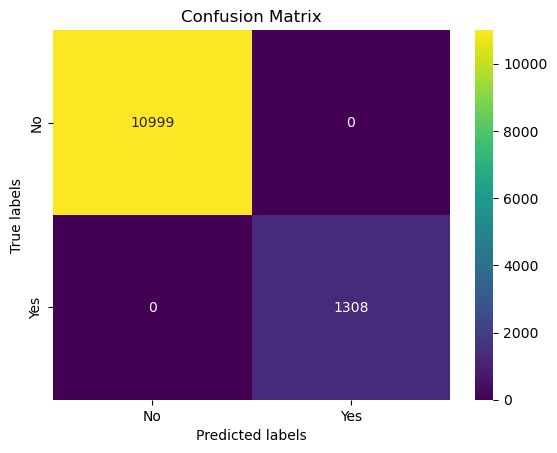

In [27]:
# Create a new instance of the Logistic Regression model with the best hyperparameters
logistic_regression_model_tuned = LogisticRegression(C=10, class_weight={0: 0.1, 1: 0.9}, penalty='l1', solver='liblinear', random_state=0)

# Fit the tuned model on the training set
logistic_regression_model_tuned.fit(X_train, y_train)

# Evaluate the tuned model on the test set
y_pred_tuned = logistic_regression_model_tuned.predict(X_test)

# Calculate test set metrics
test_accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
test_precision_tuned = precision_score(y_test, y_pred_tuned, average='weighted')
test_recall_tuned = recall_score(y_test, y_pred_tuned, average='weighted')
test_f1_tuned = f1_score(y_test, y_pred_tuned, average='weighted')

# Print the test set metrics
print(f"\nTest set metrics for the tuned model:")
print(f"Accuracy: {test_accuracy_tuned:.2f}")
print(f"Precision: {test_precision_tuned:.2f}")
print(f"Recall: {test_recall_tuned:.2f}")
print(f"F1-score: {test_f1_tuned:.2f}")

from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(confusion_matrix):
    # visualise the confusion matrix
    labels = ['No', 'Yes']
    ax = plt.subplot()
    sns.heatmap(confusion_matrix, annot=True, fmt='.0f', ax=ax, cmap='viridis')

    # labels, titles and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

# Plot the confusion matrix
confusion_matrix_tuned = confusion_matrix(y_test, y_pred_tuned)
plot_confusion_matrix(confusion_matrix_tuned)



### Feature Importance
Analyse the importance of features in the model. This can help us understand which features are contributing the most to the model's predictions and may reveal opportunities for feature engineering.

In [28]:
print(list(X_train.columns))

['icustay_id', 'gender', 'age', 'has_chartevents_data', 'weekend_admission', 'admit_day_of_week', 'admit_month', 'admit_year', 'after_hours_admission', 'admission_type_ELECTIVE', 'admission_type_EMERGENCY', 'admission_type_URGENT', 'admission_location_INFO_NOT_AVAILABLE_', 'admission_location_CLINIC_REFERRAL_PREMATURE', 'admission_location_EMERGENCY_ROOM_ADMIT', 'admission_location_HMO_REFERRAL_SICK', 'admission_location_PHYS_REFERRAL_NORMAL_DELI', 'admission_location_TRANSFER_FROM_HOSP_EXTRAM', 'admission_location_TRANSFER_FROM_OTHER_HEALT', 'admission_location_TRANSFER_FROM_SKILLED_NUR', 'admission_location_TRSF_WITHIN_THIS_FACILITY', 'discharge_location_DEAD_EXPIRED', 'discharge_location_DISC_TRAN_CANCER_CHLDRN_H', 'discharge_location_DISC_TRAN_TO_FEDERAL_HC', 'discharge_location_DISCH_TRAN_TO_PSYCH_HOSP', 'discharge_location_HOME', 'discharge_location_HOME_HEALTH_CARE', 'discharge_location_HOME_WITH_HOME_IV_PROVIDR', 'discharge_location_HOSPICE_HOME', 'discharge_location_HOSPICE_ME

In [36]:
importance = logistic_regression_model_tuned.coef_[0]
feature_names = X_train.columns.tolist()

# Create a dictionary of feature importance values
feature_importance_dict = dict(zip(feature_names, importance))

# Sort the dictionary by feature importance values (in descending order)
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top 20 feature importances
print("Top 20 Feature Importances:")
for feature, importance in sorted_feature_importances[:20]:
    print(f"{feature}: {importance}")


Top 20 Feature Importances:
discharge_location_DEAD_EXPIRED: 21.18612958984127
icd9_code_count: 0.011422792140415545
age: 0.002115181940263845
min_hourly_urineoutput: 0.00029186594633878716
gender: 0.0
has_chartevents_data: 0.0
weekend_admission: 0.0
admit_day_of_week: 0.0
admit_month: 0.0
after_hours_admission: 0.0
admission_type_ELECTIVE: 0.0
admission_type_EMERGENCY: 0.0
admission_type_URGENT: 0.0
admission_location_INFO_NOT_AVAILABLE_: 0.0
admission_location_CLINIC_REFERRAL_PREMATURE: 0.0
admission_location_EMERGENCY_ROOM_ADMIT: 0.0
admission_location_HMO_REFERRAL_SICK: 0.0
admission_location_PHYS_REFERRAL_NORMAL_DELI: 0.0
admission_location_TRANSFER_FROM_HOSP_EXTRAM: 0.0
admission_location_TRANSFER_FROM_OTHER_HEALT: 0.0


Based on the provided information, the feature importance for Discharge_Location seems to be predominantly influenced by the discharge_location_DEAD_EXPIRED value, which boasts a substantial importance score of 21.18612958984127. This suggests that this specific value serves as a potent predictor of the outcome of interest—hospital mortality. However, it is crucial to acknowledge that this value exhibits a strong correlation with the outcome itself, as it signifies that the patient passed away within the first 24 hours of ICU admission.

In light of this information, it might be judicious to exclude Discharge_Location as a feature for this task. Incorporating this feature could lead to overfitting the model to the particular value of discharge_location_DEAD_EXPIRED, as opposed to more generalizable features that may be more effective in predicting hospital mortality. Furthermore, employing a highly correlated feature could instigate bias and instability in the model, as the model may excessively emphasise the importance of that feature and face difficulties generalising to new data. Ultimately, it is essential to meticulously weigh the trade-offs between incorporating informative features and circumventing overfitting when constructing predictive models.

# Iterate and Refine

Drop the 'discharge_location' columns due to concerns about the model's potential to overfit the data and introduce bias, specifically due to the strong correlation between these features and the hospital mortality outcome. Including such highly correlated features could lead the model to rely excessively on these attributes, rather than identifying more generalisable patterns that could be helpful in predicting hospital mortality. This overemphasis on the 'discharge_location' features could negatively impact the model's performance when faced with new, unseen data, as it may struggle to generalize its findings. In addition, incorporating such features may introduce instability in the model's predictions, making it more sensitive to small fluctuations in the data. By excluding the 'discharge_location' columns, we aim to create a more robust and accurate model that can better predict hospital mortality using a broader range of relevant features.

In [5]:
# Find column names that contain 'not_measured' or 'not_tested'
columns_to_drop = [col for col in feature_engineered_df.columns 
                   if 'not_measured' in col 
                   or 'not_tested' in col 
                   or 'NICU' in col 
                   or 'min_gcs' in col 
                   or 'max_gcs' in col
                   or 'first_careunit' in col
                   or 'last_careunit' in col
                   or 'hematocrit' in col
                   or 'discharge_location' in col]

# Drop the columns from the input features
feature_engineered_df_filtered = feature_engineered_df.drop(columns=columns_to_drop, axis=1)

columns_to_drop = ['transfer_time', 'Neoplasms', 'admission_type_NEWBORN', 'any_vasopressor_used', 
                   'mechanical_vent_needed', 'max_seq_num', 'mean_seq_num', 'max_seq_num', 'median_seq_num',
                   'total_urineoutput_24h', 'endotrach_proportion']

# Drop the columns from the input features
feature_engineered_df_filtered = feature_engineered_df_filtered.drop(columns=columns_to_drop)

In [45]:
# Sanity Check
print(list(feature_engineered_df_filtered.columns))

['subject_id', 'hadm_id', 'icustay_id', 'gender', 'age', 'has_chartevents_data', 'weekend_admission', 'hospital_mortality', 'admit_day_of_week', 'admit_month', 'admit_year', 'after_hours_admission', 'admission_type_ELECTIVE', 'admission_type_EMERGENCY', 'admission_type_URGENT', 'admission_location_INFO_NOT_AVAILABLE_', 'admission_location_CLINIC_REFERRAL_PREMATURE', 'admission_location_EMERGENCY_ROOM_ADMIT', 'admission_location_HMO_REFERRAL_SICK', 'admission_location_PHYS_REFERRAL_NORMAL_DELI', 'admission_location_TRANSFER_FROM_HOSP_EXTRAM', 'admission_location_TRANSFER_FROM_OTHER_HEALT', 'admission_location_TRANSFER_FROM_SKILLED_NUR', 'admission_location_TRSF_WITHIN_THIS_FACILITY', 'insurance_Government', 'insurance_Medicaid', 'insurance_Medicare', 'insurance_Private', 'insurance_Self_Pay', 'language_BE', 'language_FU', 'language_T', 'language_SH', 'language_TO', 'language_AMH', 'language_ARA', 'language_ARM', 'language_BEN', 'language_BOS', 'language_BUL', 'language_BUR', 'language_C

### Split to Train and Test Sets

In [6]:
from sklearn.model_selection import train_test_split

# input features 
X = feature_engineered_df_filtered.drop(['hospital_mortality'], axis=1)

# Target Variable
y = feature_engineered_df_filtered['hospital_mortality']

# Split the dataset into train and test sets (75% / 25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# List of columns to impute with median values
columns_to_impute = [
    'mean_hourly_urineoutput', 'min_hourly_urineoutput',
    'max_hourly_urineoutput', 'avg_weight_naive', 'avg_gcs'
    ]

# Calculate median values from the training set
medians_train = X_train[columns_to_impute].median()

# Impute missing values in the training set with median values
X_train[columns_to_impute] = X_train[columns_to_impute].fillna(medians_train)

# Impute missing values in the test set with median values from the training set
X_test[columns_to_impute] = X_test[columns_to_impute].fillna(medians_train)

# Drop 'subject_id' and 'hadm_id' columns from X_train and X_test
X_train = X_train.drop(columns=['subject_id', 'hadm_id'])
X_test = X_test.drop(columns=['subject_id', 'hadm_id'])


In [47]:
# Calculate the correlation matrix for the entire dataset (before train-test split)
correlation_matrix = X.corr()

# Set the threshold for high correlation
high_correlation_threshold = 0.8

# Find pairs of highly correlated features
high_correlations = np.where((correlation_matrix > high_correlation_threshold) & (correlation_matrix != 1))
high_correlation_pairs = [(correlation_matrix.index[x], correlation_matrix.columns[y]) for x, y in zip(*high_correlations)]

print("Pairs of highly correlated features:")
for pair in high_correlation_pairs:
    print(pair)

Pairs of highly correlated features:


Convert boolean columns to integer

In [7]:
# Find boolean columns in X_train and X_test
boolean_columns_train = [col for col in X_train.columns if X_train[col].dtype == 'bool']
boolean_columns_test = [col for col in X_test.columns if X_test[col].dtype == 'bool']

# Combine the lists of boolean columns from X_train and X_test to ensure all relevant columns are considered
boolean_columns = list(set(boolean_columns_train + boolean_columns_test))

# Convert boolean columns to integers in X_train and X_test
X_train[boolean_columns] = X_train[boolean_columns].astype(int)
X_test[boolean_columns] = X_test[boolean_columns].astype(int)

In [8]:
### Sanity Check
# Check Column data types since scaling can only be performed on numeric columns
print("X_train info:")
print(X_train.info())

print("\nX_test info:")
print(X_test.info())

X_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 49225 entries, 57536 to 56422
Columns: 427 entries, icustay_id to avg_word2vec_99
dtypes: float64(117), int32(11), int64(56), uint8(243)
memory usage: 78.8 MB
None

X_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12307 entries, 11316 to 42172
Columns: 427 entries, icustay_id to avg_word2vec_99
dtypes: float64(117), int32(11), int64(56), uint8(243)
memory usage: 19.7 MB
None


### Model 1. Logistic Regression

In [53]:
###########################
### LOGISTIC REGRESSION ###
###########################
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, KFold 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_regression', LogisticRegression(solver='liblinear'))
])

# Define the K-Fold cross-validator
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Calculate cross-validated scores on the training set
cv_results = cross_validate(pipeline, X_train, y_train, cv=kfold, 
                            scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])

# Print the cross-validated results
print('LOGISTIC REGRESSION')
for metric, scores in cv_results.items():
    if metric.startswith("test_"):
        mean_score = scores.mean()
        std_score = scores.std()
        print(f"{metric[5:]}: {mean_score:.2f} (+/- {std_score:.2f})")

# Fit the pipeline on the training set and evaluate on the test set
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Calculate test set metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average='weighted')
test_recall = recall_score(y_test, y_pred, average='weighted')
test_f1 = f1_score(y_test, y_pred, average='weighted')

# Print the test set metrics
print(f"\nTest set metrics:")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision: {test_precision:.2f}")
print(f"Recall: {test_recall:.2f}")
print(f"F1-score: {test_f1:.2f}")


LOGISTIC REGRESSION
accuracy: 0.92 (+/- 0.00)
precision_weighted: 0.91 (+/- 0.00)
recall_weighted: 0.92 (+/- 0.00)
f1_weighted: 0.91 (+/- 0.00)

Test set metrics:
Accuracy: 0.92
Precision: 0.91
Recall: 0.92
F1-score: 0.91



Test set metrics for the tuned model:
Accuracy: 0.85
Precision: 0.92
Recall: 0.85
F1-score: 0.87


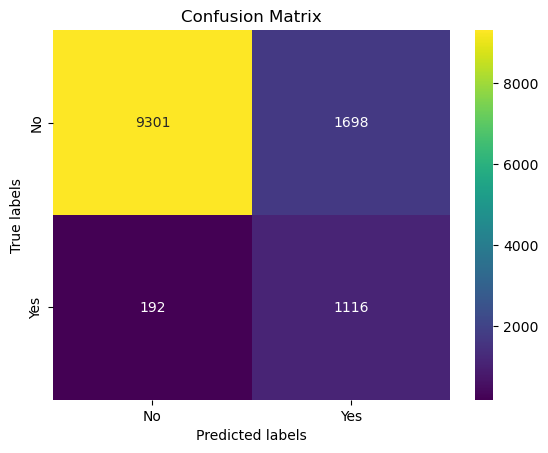

In [54]:
# Create a new instance of the Logistic Regression model with the best hyperparameters
logistic_regression_model_tuned = LogisticRegression(C=10, class_weight={0: 0.1, 1: 0.9}, penalty='l1', solver='liblinear', random_state=0)

# Fit the tuned model on the training set
logistic_regression_model_tuned.fit(X_train, y_train)

# Evaluate the tuned model on the test set
y_pred_tuned = logistic_regression_model_tuned.predict(X_test)

# Calculate test set metrics
test_accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
test_precision_tuned = precision_score(y_test, y_pred_tuned, average='weighted')
test_recall_tuned = recall_score(y_test, y_pred_tuned, average='weighted')
test_f1_tuned = f1_score(y_test, y_pred_tuned, average='weighted')

# Print the test set metrics
print(f"\nTest set metrics for the tuned model:")
print(f"Accuracy: {test_accuracy_tuned:.2f}")
print(f"Precision: {test_precision_tuned:.2f}")
print(f"Recall: {test_recall_tuned:.2f}")
print(f"F1-score: {test_f1_tuned:.2f}")

from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(confusion_matrix):
    # visualise the confusion matrix
    labels = ['No', 'Yes']
    ax = plt.subplot()
    sns.heatmap(confusion_matrix, annot=True, fmt='.0f', ax=ax, cmap='viridis')

    # labels, titles and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

# Plot the confusion matrix
confusion_matrix_tuned = confusion_matrix(y_test, y_pred_tuned)
plot_confusion_matrix(confusion_matrix_tuned)



The test set metrics for the tuned model provide valuable insights into the model's performance when predicting hospital mortality. The accuracy of 0.85 indicates that the model correctly classified 85% of the test cases, demonstrating a reasonably strong overall performance. With a precision of 0.92, the model shows a high level of reliability in its positive predictions, meaning that when the model predicts a mortality event, there is a 92% chance it is correct.

However, recall, at 0.85, reveals that the model was able to identify only 85% of the actual mortality cases in the test data. While this is still a fairly good result, it suggests that there may be room for improvement in identifying patients at risk of mortality. The F1-score, which combines precision and recall into a single metric, is 0.87. This value represents a balance between precision and recall, illustrating that the model performs well in terms of both identifying true positive cases and avoiding false positives. In summary, the test set metrics demonstrate that the tuned model exhibits satisfactory performance in predicting hospital mortality, but there may be opportunities for further enhancement, particularly in terms of recall.

#### Feature Scaling:
Using a StandardScaler can be beneficial when working with models that are sensitive to the scale of input features, such as logistic regression, support vector machines, or neural networks. The StandardScaler normalises the input features by transforming them to have a mean of 0 and a standard deviation of 1. This scaling can improve the model's performance by ensuring that all features contribute equally to the model, preventing any single feature from dominating the model due to its scale.

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confusion_matrix(confusion_matrix):
    # visualise the confusion matrix
    labels = ['No', 'Yes']
    ax = plt.subplot()
    sns.heatmap(confusion_matrix, annot=True, fmt='.0f', ax=ax, cmap='viridis')

    # labels, titles and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)


Test set metrics for the tuned model:
Accuracy: 0.85
Precision: 0.92
Recall: 0.85
F1-score: 0.87


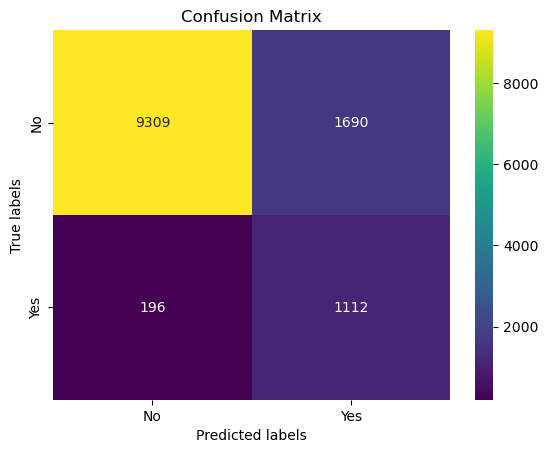

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, KFold 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Initialise the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the fitted scaler
X_test_scaled = scaler.transform(X_test)

# Create a new instance of the Logistic Regression model with the best hyperparameters
logistic_regression_model_tuned = LogisticRegression(C=10, class_weight={0: 0.1, 1: 0.9}, penalty='l1', solver='liblinear', random_state=0)

# Fit the tuned model on the scaled training set
logistic_regression_model_tuned.fit(X_train_scaled, y_train)

# Evaluate the tuned model on the scaled test set
y_pred_tuned = logistic_regression_model_tuned.predict(X_test_scaled)

# Calculate test set metrics
test_accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
test_precision_tuned = precision_score(y_test, y_pred_tuned, average='weighted')
test_recall_tuned = recall_score(y_test, y_pred_tuned, average='weighted')
test_f1_tuned = f1_score(y_test, y_pred_tuned, average='weighted')

# Print the test set metrics
print(f"\nTest set metrics for the tuned model:")
print(f"Accuracy: {test_accuracy_tuned:.2f}")
print(f"Precision: {test_precision_tuned:.2f}")
print(f"Recall: {test_recall_tuned:.2f}")
print(f"F1-score: {test_f1_tuned:.2f}")

# Plot the confusion matrix
confusion_matrix_tuned = confusion_matrix(y_test, y_pred_tuned)
plot_confusion_matrix(confusion_matrix_tuned)


#### Feature Importance

Top 50 Feature Importances:
language_JAPA: 2.7869438688260586
language_AMH: 2.77208754829258
ethnicity_ASIAN_OTHER: 2.7047527814474086
spo2_mean_status_high: 2.427026660801221
avg_word2vec_15: 2.4149129776878846
avg_word2vec_93: 2.3636018445210607
avg_word2vec_2: 2.287502551159587
avg_word2vec_80: 2.2777675186192994
avg_word2vec_4: 2.2543293787706307
avg_word2vec_81: 2.1889797059061076
age_group_age_greater_than_65: 2.1541264581552837
ethnicity_NATIVE_HAWAIIAN_OR_OTHER_PACIFIC_ISLANDER: 2.103730275230878
creatinine_range_high: 1.950011700498433
creatinine_range_low: 1.9027739309728462
avg_word2vec_50: 1.900287349350133
avg_word2vec_72: 1.8640969889924188
avg_word2vec_84: 1.856700484479322
avg_word2vec_58: 1.7753625927798489
chloride_range_low: 1.757062835543063
avg_word2vec_88: 1.753762332478263
avg_word2vec_83: 1.7528774183679805
creatinine_range_normal: 1.7469784267694983
glucose_range_low: 1.7071483424464857
ethnicity_ASIAN_CAMBODIAN: 1.65193532697641
avg_word2vec_8: 1.5123401721426

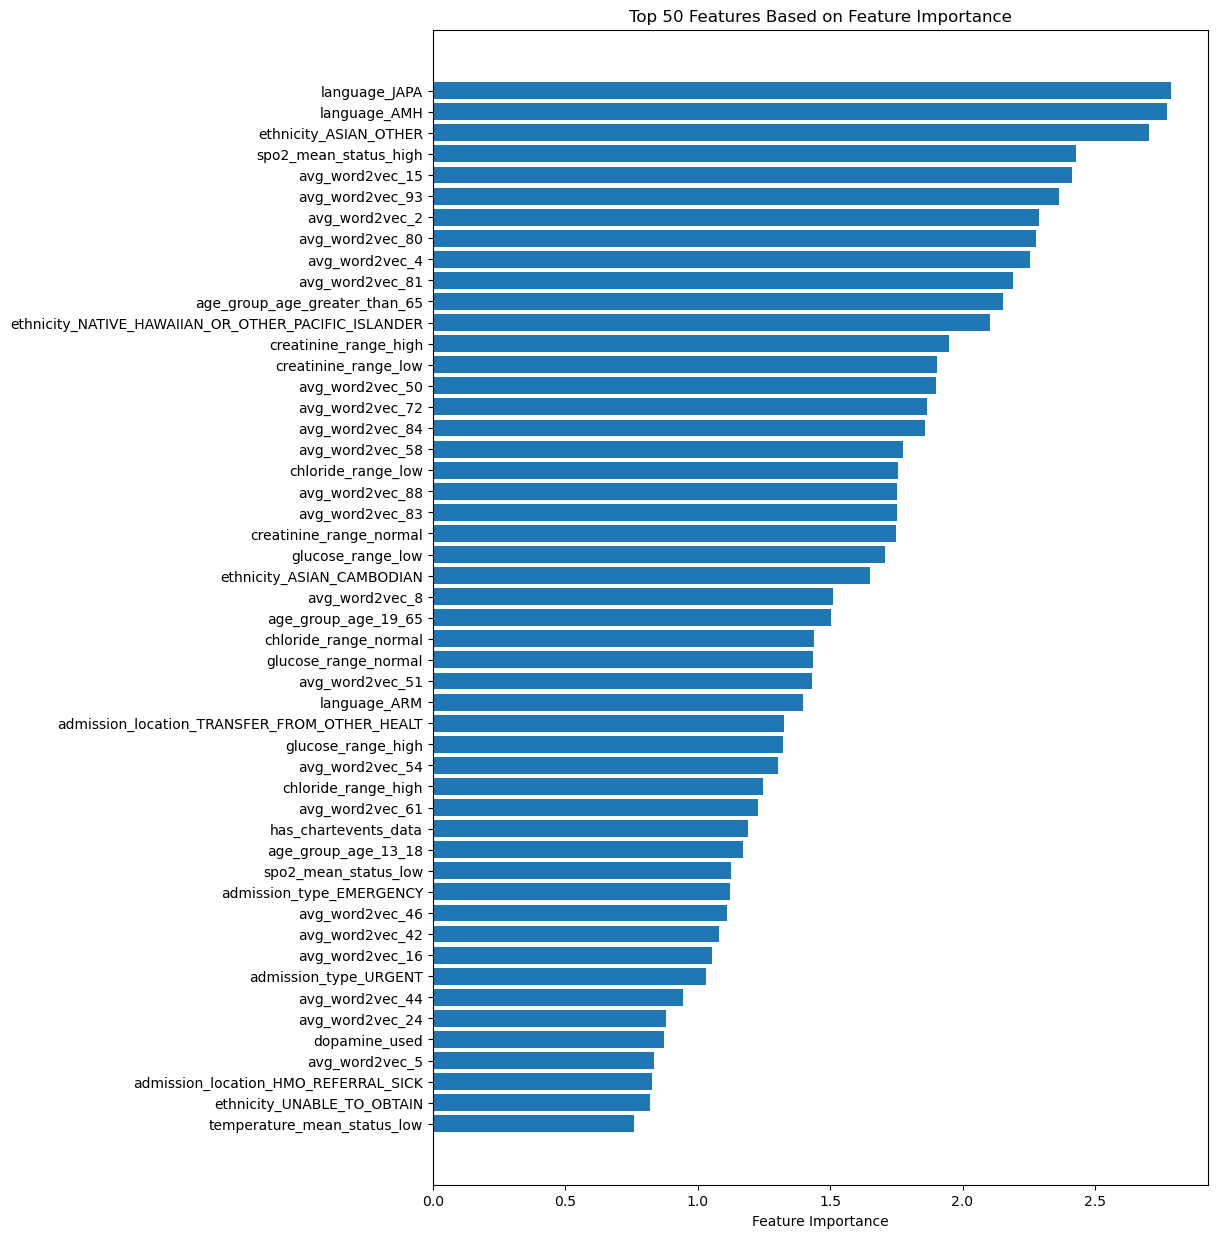

In [55]:
import matplotlib.pyplot as plt

importance = logistic_regression_model_tuned.coef_[0]
feature_names = X_train.columns.tolist()

# Create a dictionary of feature importance values
feature_importance_dict = dict(zip(feature_names, importance))

# Sort the dictionary by feature importance values (in descending order)
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top 50 feature importances
print("Top 50 Feature Importances:")
for feature, importance in sorted_feature_importances[:50]:
    print(f"{feature}: {importance}")

# Create a horizontal bar plot of the top 50 feature importances
top_50_features, top_50_importances = zip(*sorted_feature_importances[:50])

plt.figure(figsize=(10, 15))
plt.barh(range(len(top_50_features)), top_50_importances)
plt.yticks(range(len(top_50_features)), top_50_features)
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
plt.xlabel('Feature Importance')
plt.title('Top 50 Features Based on Feature Importance')
plt.show()


# Model 2: Random Forest  

Decision tree-based models, such as random forests, are not sensitive to the scale of input features. The process of building decision trees involves splitting the data based on feature values, so the absolute values of features do not impact the model's performance. In this case, using a StandardScaler would not have a significant effect on the random forest model's performance.

In [56]:
#####################
### RANDOM FOREST ###
#####################
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Create a pipeline with StandardScaler and Random Forest Classifier
random_forest_model = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=42))

# Define the K-Fold cross-validator
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Calculate cross-validated scores on the training set
cv_results_rf = cross_validate(random_forest_model, X_train, y_train, cv=kfold, 
                               scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])

# Print the cross-validated results
print("RANDOM FOREST")
for metric, scores in cv_results_rf.items():
    if metric.startswith("test_"):
        mean_score = scores.mean()
        std_score = scores.std()
        print(f"{metric[5:]}: {mean_score:.2f} (+/- {std_score:.2f})")

# Fit the model on the training set and evaluate on the test set
random_forest_model.fit(X_train, y_train)
y_pred_rf = random_forest_model.predict(X_test)

# Calculate test set metrics
test_accuracy_rf = accuracy_score(y_test, y_pred_rf)
test_precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
test_recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
test_f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

# Print the test set metrics
print(f"\nTest set metrics:")
print(f"Accuracy: {test_accuracy_rf:.2f}")
print(f"Precision: {test_precision_rf:.2f}")
print(f"Recall: {test_recall_rf:.2f}")
print(f"F1-score: {test_f1_rf:.2f}")


RANDOM FOREST
accuracy: 0.92 (+/- 0.00)
precision_weighted: 0.92 (+/- 0.00)
recall_weighted: 0.92 (+/- 0.00)
f1_weighted: 0.89 (+/- 0.00)

Test set metrics:
Accuracy: 0.92
Precision: 0.91
Recall: 0.92
F1-score: 0.89


## Model Comparison

Both Logistic Regression and Random Forest models have achieved similar performance metrics on cross-validation and test set evaluation.  

We will use the Logistic Regression model since it is a simpler model.

## Model Interpretability

**1. SHAP**  
SHAP plots provide a visual representation of the feature importance and their impact on the model's output for a specific instance or a group of instances.

**a) SHAP Summary Plot**  
A SHAP summary plot shows the global importance of features across all instances in the dataset. In this plot, the features are sorted by their absolute SHAP values, with the most important features at the top. Each dot represents an instance, and the x-axis indicates the SHAP value for that instance. The color of the dot indicates the feature value (red for high values, blue for low values).

* **Features with the highest absolute SHAP values**: these features have the most significant impact on the model's predictions.  

* **Distribution of dots for each feature**: Distribution helps us understand how the feature values impact the predictions. A wide distribution indicates that the feature has varying effects on the model's output. If the dots are spread across the horizontal axis, it implies that the feature has a diverse impact on the model's predictions. If the dots are concentrated around a specific SHAP value, it indicates that the feature's impact on the model's predictions is consistent.

* **Colour of the dots for each feature**: A mix of blue and red dots indicates that both high and low feature values can have a significant impact on the predictions.

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


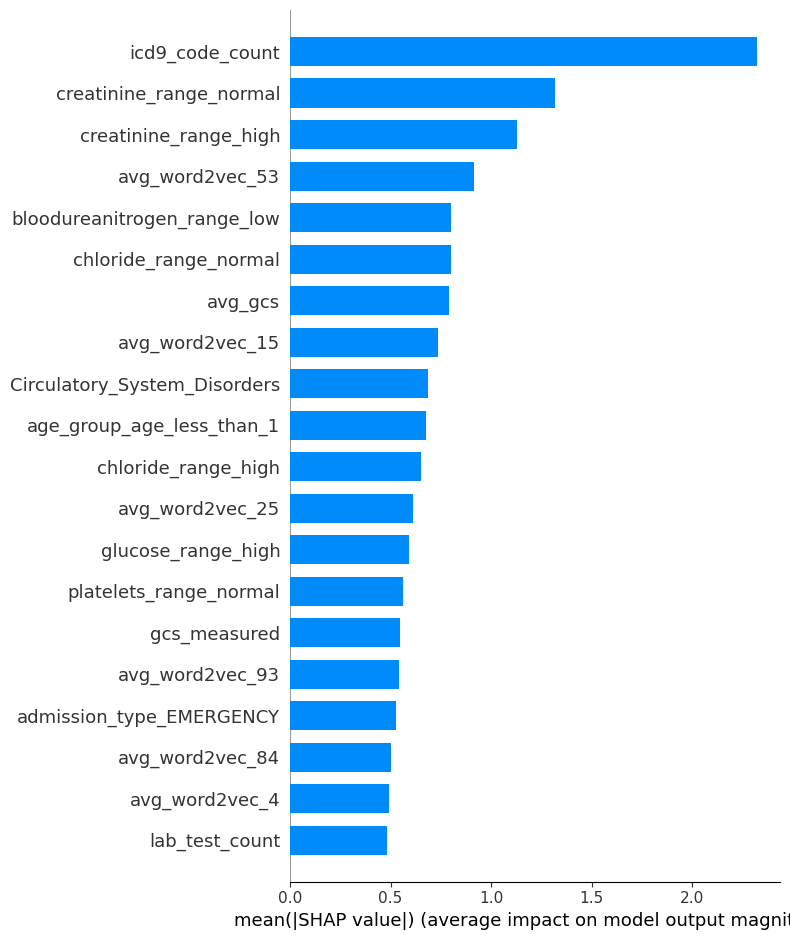

In [15]:
import shap

# Initialise the SHAP explainer for the logistic regression model
# Create a SHAP explainer for the logistic regression model
explainer_shap = shap.LinearExplainer(logistic_regression_model_tuned, X_train_scaled, feature_dependence="independent")

# Compute SHAP values for the scaled test set
shap_values = explainer_shap.shap_values(X_test_scaled)

# Visualize the SHAP values for the chosen instance
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar", feature_names=X_test.columns)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


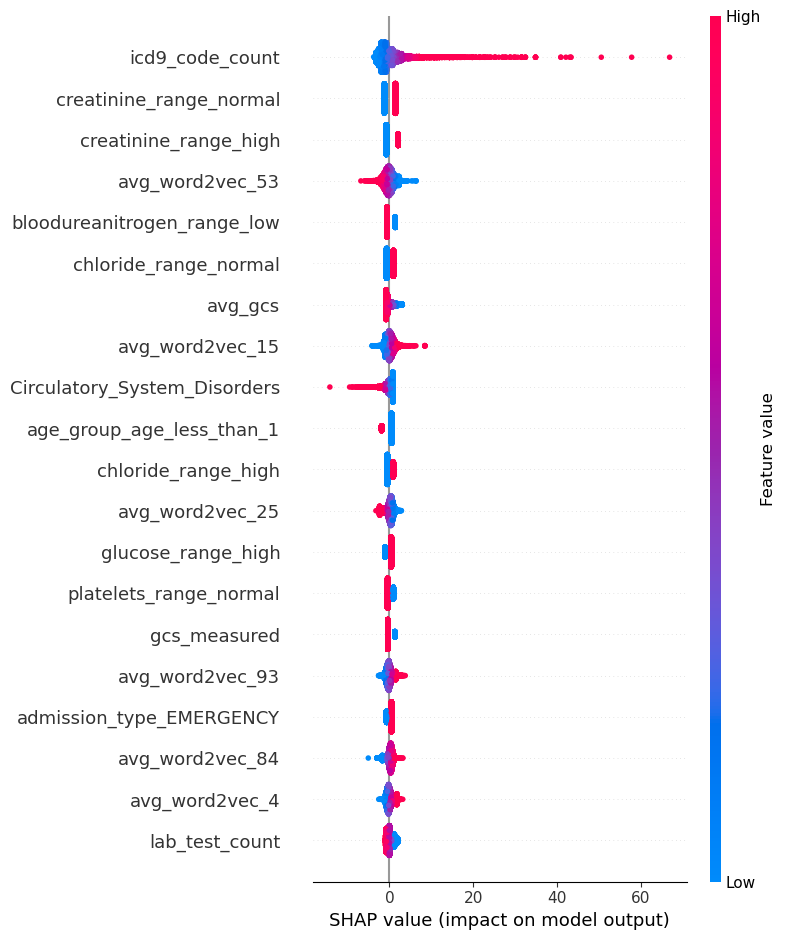

In [17]:
# Create a SHAP summary plot
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns)

#### Mean absolute SHAP values for each feature in descending order based on the summary plot

In [21]:
# Calculate the mean absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

# Create a dictionary with feature names and their mean absolute SHAP values
feature_shap_dict = dict(zip(instance_feature_names, mean_abs_shap_values))

# Sort the dictionary in descending order based on the mean absolute SHAP values
sorted_feature_shap_dict = sorted(feature_shap_dict.items(), key=lambda x: x[1], reverse=True)

# Print the sorted features and their mean absolute SHAP values
print("Sorted Mean Absolute SHAP Values:")
for feature, mean_abs_shap_value in sorted_feature_shap_dict:
    print(f"{feature}: {mean_abs_shap_value: .4f}")

Sorted Mean Absolute SHAP Values:
icd9_code_count:  2.3191
creatinine_range_normal:  1.3176
creatinine_range_high:  1.1284
avg_word2vec_53:  0.9157
bloodureanitrogen_range_low:  0.8023
chloride_range_normal:  0.7999
avg_gcs:  0.7910
avg_word2vec_15:  0.7334
Circulatory_System_Disorders:  0.6879
age_group_age_less_than_1:  0.6779
chloride_range_high:  0.6519
avg_word2vec_25:  0.6102
glucose_range_high:  0.5921
platelets_range_normal:  0.5601
gcs_measured:  0.5486
avg_word2vec_93:  0.5414
admission_type_EMERGENCY:  0.5284
avg_word2vec_84:  0.5020
avg_word2vec_4:  0.4944
lab_test_count:  0.4834
avg_word2vec_80:  0.4653
endotracheal_intubation:  0.4479
sodium_range_normal:  0.4397
avg_word2vec_49:  0.4344
avg_word2vec_2:  0.4339
avg_word2vec_58:  0.4159
bicarbonate_range_normal:  0.4087
avg_weight_naive:  0.4015
language_ENGL:  0.3964
avg_word2vec_17:  0.3949
avg_word2vec_82:  0.3895
avg_word2vec_50:  0.3769
avg_word2vec_99:  0.3768
avg_word2vec_81:  0.3687
avg_word2vec_68:  0.3614
avg_wor

**b) SHAP Individual Instance Plot:**  
An individual instance plot displays the SHAP values for a specific instance. The plot is a horizontal bar chart, where each bar represents a feature, and the length of the bar indicates the magnitude of the SHAP value for that feature.  

Positive SHAP values push the prediction higher, while negative SHAP values push the prediction lower.  

To interpret an individual instance plot:

* Look for features with the highest positive SHAP values; these features contribute the most to increasing the predicted outcome for that instance.
* Look for features with the highest negative SHAP values; these features contribute the most to decreasing the predicted outcome for that instance.
* Compare the SHAP values of different features to understand their relative importance in the model's decision-making process for that instance.

In [22]:
# Visualise the SHAP values for a specific instance:
# Choose an instance index from the test set
instance_index = 10

# Get the SHAP values for the chosen instance
instance_shap_values = shap_values[instance_index]

# Get the feature names and values for the chosen instance
instance_feature_names = X_test.columns
instance_feature_values = X_test.iloc[instance_index]

# Create a list of tuples containing feature name, feature value, and corresponding SHAP value
feature_shap_list = [(feature, value, shap_value) for feature, value, shap_value in zip(instance_feature_names, instance_feature_values, instance_shap_values)]

# Sort the list in descending order based on the absolute SHAP values
sorted_feature_shap_list = sorted(feature_shap_list, key=lambda x: abs(x[2]), reverse=True)

# Print the sorted features and their corresponding SHAP values
print(f"Sorted SHAP values for instance at index {instance_index}:")
for feature, value, shap_value in sorted_feature_shap_list:
    print(f"{feature} (value: {value:.4f}): {shap_value: .4f}")


Sorted SHAP values for instance at index 10:
icd9_code_count (value: 3.0000): -2.8788
avg_word2vec_80 (value: -0.4108): -1.8224
avg_word2vec_50 (value: 0.6886):  1.6982
avg_word2vec_15 (value: 0.6500):  1.5293
creatinine_range_normal (value: 1.0000):  1.4216
avg_gcs (value: 8.0000):  1.3613
avg_word2vec_25 (value: -0.8130):  1.2506
avg_word2vec_58 (value: -0.5885): -1.0644
avg_word2vec_62 (value: 0.5934): -0.9664
avg_word2vec_72 (value: -0.2285): -0.9509
chloride_range_normal (value: 1.0000):  0.9385
avg_word2vec_87 (value: 1.0313): -0.9260
glucose_mean_status_normal (value: 1.0000): -0.8823
avg_word2vec_73 (value: 0.6600): -0.8096
long_title_num_words (value: 2.3333): -0.7800
creatinine_range_high (value: 0.0000): -0.7653
avg_word2vec_93 (value: -0.3851): -0.7463
avg_word2vec_16 (value: -0.5604): -0.7364
avg_word2vec_8 (value: -0.4954): -0.7361
avg_word2vec_44 (value: -0.8692): -0.7358
avg_word2vec_53 (value: 0.2207):  0.7345
avg_word2vec_81 (value: 0.6295):  0.7299
avg_word2vec_11 (v

**2. Lime**  

The plot produced by LIME is a local feature importance plot for the specific instance chosen from the test set. It shows the contributions of each feature to the model's prediction for that instance. 

* Each bar in the plot represents a feature that has the most significant impact on the prediction for the chosen instance.

* The length of each bar corresponds to the magnitude of the feature's contribution to the prediction.

* Positive contributions (blue bars) push the prediction towards the positive class ('Yes'), while negative contributions (red bars) push the prediction towards the negative class ('No').

* The base value (the dashed line) is the average prediction for all instances, and the arrow shows the model's prediction for the specific instance.

* The features in the plot are ordered by their absolute contribution, with the top feature having the highest impact on the prediction.

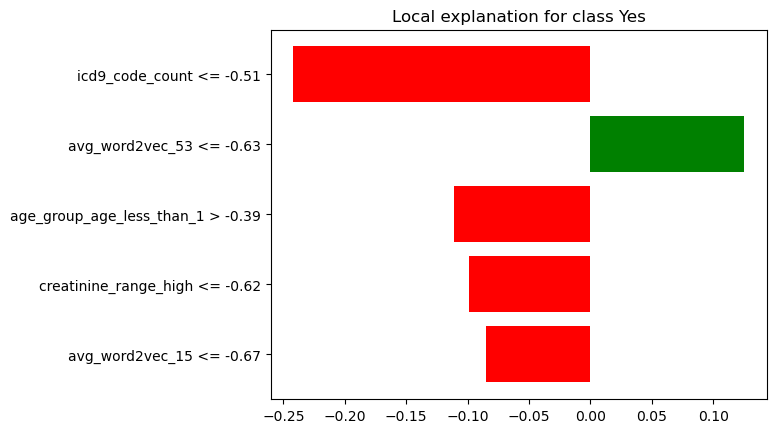

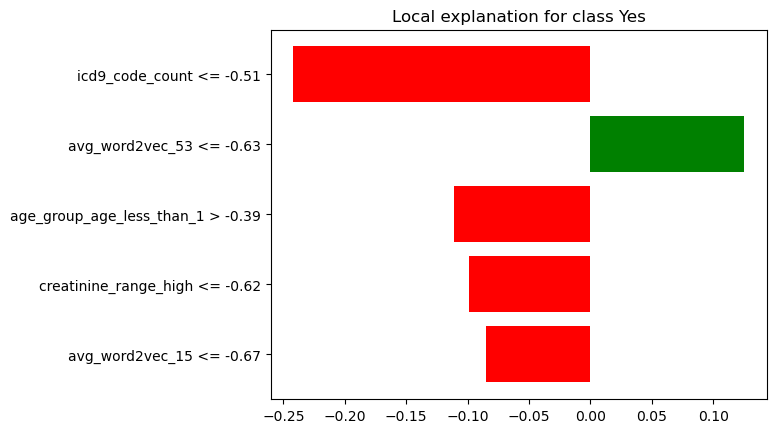

In [16]:
from lime import lime_tabular

# Initialise the LIME explainer for the logistic regression model:
# Create a LIME explainer for the logistic regression model
explainer_lime = lime_tabular.LimeTabularExplainer(X_train_scaled, feature_names=X_train.columns.tolist(), class_names=['No', 'Yes'], discretize_continuous=True)

# Explain a specific instance using LIME:
# Choose an instance index from the test set
instance_index = 0

# Explain the instance using the LIME explainer
exp = explainer_lime.explain_instance(X_test_scaled[instance_index], logistic_regression_model_tuned.predict_proba, num_features=5)

# Visualise the explanation
exp.as_pyplot_figure()